<a href="https://colab.research.google.com/github/sbalram123/CoronaBatch-Session4/blob/master/SB_CoronaBatch_A6_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Take the 5th code from assignment 4 .
#run your model for 25 epochs for each:
# without L1/L2 with BN
# without L1/L2 with GBN
# with L1 with BN
# with L1 with GBN
# with L2 with BN
# with L2 with GBN
# with L1 and L2 with BN
# with L1 and L2 with GBN
# You cannot be running your code 8 times manually (-500 points for that). You need to be smarter and write a single loop or iterator to iterate through these conditions. 
# draw ONE graph to show the validation accuracy curves for all 8 jobs above. This graph must have proper legends and it should be clear what we are looking at. 
# draw ONE graph to show the loss change curves for all 8 jobs above. This graph must have proper legends and it should be clear what we are looking at. 
# find any 25 misclassified images for "without L1/L2 with BN" AND "without L1/L2 with GBN" model. You should be using the saved model from the above jobs. 
# and L2 models. You MUST show the actual and predicted class names.
# make all the images available on Github Readme page, so you can upload the images for your assignment (you can upload them somewhere else as well for add image url).
# submit the Github link for your notebook with logs, and also upload the images in the S6-Assignment Solution. 

In [2]:
# The gods
from __future__ import print_function
!pip install torchsummary
from torchsummary import summary
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import pdb # Python Debugger Lib
from itertools import chain
from inspect import signature
from functools import lru_cache as cache
from collections import defaultdict, namedtuple


In [0]:
class TrainTestUtils(object):

    def __init__(self):
        self.train_losses = []
        self.test_losses = []
        self.train_acc = []
        self.test_acc = []
        self.train_min_loss = []
        self.train_max_acc = []
        self.misclassifiedImages = []

    @staticmethod
    def get_device():
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda" if use_cuda else "cpu")
        return device

    @staticmethod
    def display_summary(model_obj, input_image_size):
        # model_obj: class objec
        # input_image_size: type int size of the image
        device = TrainTestUtils.get_device()
        print("device")
        model = model_obj.to(device)
        summary(model, input_size=(1, input_image_size, input_image_size))

    @staticmethod
    def get_train_transforms(mean=0.1307, std=0.3081):
        # Train Phase transformations normal
        train_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((mean,), (std,))  # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
            # Note the difference between (0.1307) and (0.1307,)
        ])
        return train_transforms


    def get_train_transforms_rotaion(mean=0.1307, std=0.3081):
        # Train Phase transformations with rotation
        train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-6.2, 6.2), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((mean,), (std,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       ])
        return train_transforms


    def get_test_transforms(mean=0.1307, std=0.3081):
        # Test Phase transformations
        test_transforms = transforms.Compose([
            #  transforms.Resize((28, 28)),
            #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize((mean,), (std,))
        ])
        return test_transforms


    def get_mean_std(path='./data', print_log=False, display_log=True):
        # simple transform
        simple_transforms = transforms.Compose([
            transforms.ToTensor(),
        ])
        exp = datasets.MNIST(path, train=True, download=True, transform=simple_transforms)
        exp_data = exp.train_data
        exp_data = exp.transform(exp_data.numpy())
        mean = torch.mean(exp_data)
        std =  torch.std(exp_data)
        if display_log:
          print('[Train]')
          print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
          print(' - Tensor Shape:', exp.train_data.size())
          print(' - min:', torch.min(exp_data))
          print(' - max:', torch.max(exp_data))
          print(' - mean:', mean)
          print(' - std:', std)
          print(' - var:', torch.var(exp_data))
        return mean, std


    def get_train_test_data_set(self, train_transforms=None, test_transforms=None, path='./data', display_log=False):
        mean, std = TrainTestUtils.get_mean_std(path=path, display_log=display_log)
        if train_transforms is None:
            train_transforms = TrainTestUtils.get_train_transforms_rotaion()
        if test_transforms is None:
            test_transforms = TrainTestUtils.get_test_transforms()
        train = datasets.MNIST(path, train=True, download=True, transform=train_transforms)
        test = datasets.MNIST(path, train=False, download=True, transform=test_transforms)
        return train, test

    
    def get_data_loader(self, train, test, batch_size=128):
        SEED = 1
        # CUDA?
        cuda = torch.cuda.is_available()
        print("CUDA Available?", cuda)

        # For reproducibility
        torch.manual_seed(SEED)

        if cuda:
            torch.cuda.manual_seed(SEED)

        # dataloader arguments - something you'll fetch these from cmdprmt
        dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

        # train dataloader
        train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

        # test dataloader
        test_loader = torch.utils.data.DataLoader(test, **dataloader_args)
        return train_loader, test_loader

    def train(self, model, device, train_loader, optimizer, epoch, l1_factor=None):
      model.train()
      pbar = tqdm(train_loader)
      correct = 0
      processed = 0
      for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        #pdb.set_trace()
        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        #update l1 regularizer if requested
        if l1_factor:
          loss = self.apply_l1_regularizer(loss, model, l1_factor)

        self.train_losses.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm
        
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Train Set: Train Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        acc = float("{:.2f}".format(100*correct/processed))
        #self.train_acc.append(100*correct/processed)
        self.train_acc.append(acc)

    def test(self, model, device, test_loader):
        model.eval()
        test_loss = 0
        correct = 0
        self.misclassifiedImages = []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                target_change = target.view_as(pred)
                for i in range(len(pred)):
                  if pred[i].item()!= target_change[i].item():
                    self.misclassifiedImages.append([data[i], pred[i], target_change[i]])
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        self.test_losses.append(test_loss)
        print("Number of miscalssified Images = ",len(self.misclassifiedImages))

        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

        self.test_acc.append(100. * correct / len(test_loader.dataset))



    def train_test_model(self, model, EPOCHS=25, batch_size=128, path='./data', optimizer=None, train_transforms=None, test_transforms=None, l1_factor=None):
        # Train and test our model
        if optimizer is None:
            optimizer = self.get_optimizer(model, lr=0.01, momentum=0.9)
        train, test =  self.get_train_test_data_set(path=path, train_transforms=train_transforms, test_transforms=test_transforms)
        train_loader, test_loader = self.get_data_loader(train, test, batch_size)
        for epoch in range(1, EPOCHS+1):
            print("EPOCH:", epoch)
            self.train(model, device, train_loader, optimizer, epoch, l1_factor=l1_factor)
            self.test(model, device, test_loader)
            self.train_max_acc.append(self.train_acc[-1])
            self.train_min_loss.append(self.train_losses[-1])

    def calculate_diff(train, test):
        zip_obj = zip(train, test)
        diff = [train_i-test_i for train_i, test_i in zip_obj]
        return diff


    def get_optimizer(self, model, lr=0.01, momentum=0.9):
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
        return optimizer

    def get_step_optimizer(self, model, lr=0.01, momentum=0.9, step_size=1, gamma=0.1):
       optimizer = self.get_optimizer(model, lr, momentum)
       scheduler = StepLR(optimizer, step_size, gamma)
       return optimizer

    def apply_l1_regularizer(self, loss, model, l1_factor=0.00008):
        l1_crit = nn.L1Loss(size_average=False)
        reg_loss = 0
        parameters = model.parameters()
        for param in parameters:
          reg_loss += torch.sum(param.abs())
          # zero_vector = torch.rand_like(param) * 0
          # reg_loss += l1_crit(param, zero_vector)
        loss += l1_factor * reg_loss
        return loss

    def apply_l2_regularizer(self, model, weight_decay, lr=0.01, momentum=0.9):
        l2_regularizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
        return l2_regularizer

    
    def plot_misclassified(self, misclassifiedImages):
      fig = plt.figure(figsize = (10,10))
      for i in range(25):
        sub = fig.add_subplot(5, 5, i+1)
        plt.imshow(misclassifiedImages[i][0].cpu().numpy().squeeze(),cmap='gray',interpolation='none')
        sub.set_title("Pred={}, Act={}".format(str(misclassifiedImages[i][1].data.cpu().numpy()),str(misclassifiedImages[i][2].data.cpu().numpy())))       
      plt.tight_layout()
      plt.show()

    def plot_test_loss_acc(self,test_losses,test_acc):
      fig, axs = plt.subplots(1,2,figsize=(15,10))
      axs[0].plot(test_losses)
      axs[0].set_title("Test Loss")
      axs[1].plot(test_acc)
      axs[1].set_title("Test Accuracy")

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        try:
            return False
        except Exception as e:
            pass

In [0]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias

In [0]:
class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

In [0]:
def norm2d(output_channels, batch_type="BN"):
    if batch_type == "GBN":
        num_splits = 2
        return GhostBatchNorm(output_channels,num_splits)
    else:
        return nn.BatchNorm2d(output_channels)

In [0]:
dropout = 0.09
class Net(nn.Module):
    def __init__(self, batch_type="BN"):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 10, 3,bias=False),
                                   nn.ReLU(),
                                  #  nn.BatchNorm2d(10),
                                   norm2d(10, batch_type),
                                   nn.Dropout2d(dropout),
                                   
                                   nn.Conv2d(10, 20, 3,bias=False),
                                   nn.ReLU(),
                                  #  nn.BatchNorm2d(20),
                                   norm2d(20, batch_type),
                                   nn.Dropout2d(dropout),

                                   nn.Conv2d(20, 10, 1,bias=False),

                                   nn.MaxPool2d(2, 2),

                                   nn.Conv2d(10, 20, 3,bias=False),
                                   nn.ReLU(),
                                  #  nn.BatchNorm2d(20),
                                   norm2d(20, batch_type),
                                   nn.Dropout2d(dropout),

                                   nn.Conv2d(20, 16, 3,bias=False),
                                   nn.ReLU(),
                                  #  nn.BatchNorm2d(16),
                                   norm2d(16, batch_type),
                                   nn.Dropout2d(dropout),
                                   
                                   nn.Conv2d(16, 10, 3,bias=False),
                                   nn.ReLU(),
                                  #  nn.BatchNorm2d(10),
                                   norm2d(10, batch_type),
                                   nn.Dropout2d(dropout),

                                   nn.Conv2d(10, 16, 3,padding =1,bias=False),
                                   nn.ReLU(),
                                  #  nn.BatchNorm2d(16),
                                   norm2d(16, batch_type),
                                   nn.Dropout2d(dropout),
                                   
                                   nn.AvgPool2d(kernel_size=6),
                                   nn.Conv2d(16, 10, 1,bias=False))

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [0]:
#BN WITHOUT L1L2 initialized
bn_test_without_L1L2_Loss = []
bn_test_without_L1L2_acc = []
bn_misclassifiedwithoutL1L2= []

#BN WITH L1 initialized
bn_test_with_L1_Loss = []
bn_test_with_L1_acc = []
bn_misclassifiedL1 = []

#BN WITH L2 initialized
bn_test_with_L2_Loss = []
bn_test_with_L2_acc = []
bn_misclassifiedL2 = []

#BN WITH L1L2 initialized
bn_test_with_L1L2_Loss = []
bn_test_with_L1L2_acc = []
bn_misclassifiedL1L2 = []

#GBN WITHOUT L1L2 initialized
gbn_test_without_L1L2_Loss = []
gbn_test_without_L1L2_acc = []
gbn_misclassifiedwithoutL1L2 = []

#GBN WITH L1 initialized
gbn_test_with_L1_Loss = []
gbn_test_with_L1_acc = []
gbn_misclassifiedL1 = []

#GBN WITH L2 initialized
gbn_test_with_L2_Loss = []
gbn_test_with_L2_acc = []
gbn_misclassifiedL2 = []

#GBN WITH L1L2 initialized
gbn_test_with_L1L2_Loss = []
gbn_test_with_L1L2_acc = []
gbn_misclassifiedL1L2 = []

EPOCHS = 25
GBN_BATCHSIZE = 64
BN_BATCHSIZE = 32

device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
    GhostBatchNorm-3           [-1, 10, 26, 26]              20
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
    GhostBatchNorm-7           [-1, 20, 24, 24]              40
         Dropout2d-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 20, 10, 10]           1,800
             ReLU-12           [-1, 20, 10, 10]               0
   GhostBatchNorm-13           [-1, 20, 10, 10]              40
        Dropout2d-14           [

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/938 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1










Train Set: Train Loss=0.2791658639907837 Batch_id=937 Accuracy=86.10: 100%|██████████| 938/938 [00:18<00:00, 49.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  164

Test set: Average loss: 0.0567, Accuracy: 9836/10000 (98.36%)

EPOCH: 2


Train Set: Train Loss=0.027298778295516968 Batch_id=937 Accuracy=95.48: 100%|██████████| 938/938 [00:19<00:00, 49.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  107

Test set: Average loss: 0.0376, Accuracy: 9893/10000 (98.93%)

EPOCH: 3


Train Set: Train Loss=0.15055055916309357 Batch_id=937 Accuracy=96.60: 100%|██████████| 938/938 [00:18<00:00, 49.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  101

Test set: Average loss: 0.0325, Accuracy: 9899/10000 (98.99%)

EPOCH: 4


Train Set: Train Loss=0.023181453347206116 Batch_id=937 Accuracy=96.92: 100%|██████████| 938/938 [00:18<00:00, 50.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  95

Test set: Average loss: 0.0295, Accuracy: 9905/10000 (99.05%)

EPOCH: 5


Train Set: Train Loss=0.12617778778076172 Batch_id=937 Accuracy=97.21: 100%|██████████| 938/938 [00:18<00:00, 50.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  90

Test set: Average loss: 0.0272, Accuracy: 9910/10000 (99.10%)

EPOCH: 6


Train Set: Train Loss=0.11550337076187134 Batch_id=937 Accuracy=97.48: 100%|██████████| 938/938 [00:18<00:00, 50.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  83

Test set: Average loss: 0.0255, Accuracy: 9917/10000 (99.17%)

EPOCH: 7


Train Set: Train Loss=0.20059359073638916 Batch_id=937 Accuracy=97.58: 100%|██████████| 938/938 [00:18<00:00, 50.98it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  77

Test set: Average loss: 0.0255, Accuracy: 9923/10000 (99.23%)

EPOCH: 8


Train Set: Train Loss=0.14009711146354675 Batch_id=937 Accuracy=97.63: 100%|██████████| 938/938 [00:18<00:00, 50.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  86

Test set: Average loss: 0.0248, Accuracy: 9914/10000 (99.14%)

EPOCH: 9


Train Set: Train Loss=0.12161408364772797 Batch_id=937 Accuracy=97.63: 100%|██████████| 938/938 [00:18<00:00, 50.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  74

Test set: Average loss: 0.0234, Accuracy: 9926/10000 (99.26%)

EPOCH: 10


Train Set: Train Loss=0.08185334503650665 Batch_id=937 Accuracy=97.86: 100%|██████████| 938/938 [00:18<00:00, 50.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  66

Test set: Average loss: 0.0233, Accuracy: 9934/10000 (99.34%)

EPOCH: 11


Train Set: Train Loss=0.014544129371643066 Batch_id=937 Accuracy=97.92: 100%|██████████| 938/938 [00:18<00:00, 50.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  67

Test set: Average loss: 0.0238, Accuracy: 9933/10000 (99.33%)

EPOCH: 12


Train Set: Train Loss=0.11248068511486053 Batch_id=937 Accuracy=97.93: 100%|██████████| 938/938 [00:18<00:00, 50.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  73

Test set: Average loss: 0.0220, Accuracy: 9927/10000 (99.27%)

EPOCH: 13


Train Set: Train Loss=0.11697913706302643 Batch_id=937 Accuracy=97.92: 100%|██████████| 938/938 [00:18<00:00, 49.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  70

Test set: Average loss: 0.0233, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Train Set: Train Loss=0.3616679012775421 Batch_id=937 Accuracy=98.08: 100%|██████████| 938/938 [00:18<00:00, 50.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  61

Test set: Average loss: 0.0207, Accuracy: 9939/10000 (99.39%)

EPOCH: 15


Train Set: Train Loss=0.06802881509065628 Batch_id=937 Accuracy=97.96: 100%|██████████| 938/938 [00:18<00:00, 50.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  65

Test set: Average loss: 0.0215, Accuracy: 9935/10000 (99.35%)

EPOCH: 16


Train Set: Train Loss=0.09163018316030502 Batch_id=937 Accuracy=98.10: 100%|██████████| 938/938 [00:19<00:00, 48.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  56

Test set: Average loss: 0.0201, Accuracy: 9944/10000 (99.44%)

EPOCH: 17


Train Set: Train Loss=0.07151743769645691 Batch_id=937 Accuracy=98.15: 100%|██████████| 938/938 [00:19<00:00, 48.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  52

Test set: Average loss: 0.0188, Accuracy: 9948/10000 (99.48%)

EPOCH: 18


Train Set: Train Loss=0.019686326384544373 Batch_id=937 Accuracy=98.07: 100%|██████████| 938/938 [00:19<00:00, 48.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  62

Test set: Average loss: 0.0197, Accuracy: 9938/10000 (99.38%)

EPOCH: 19


Train Set: Train Loss=0.008139073848724365 Batch_id=937 Accuracy=98.11: 100%|██████████| 938/938 [00:19<00:00, 49.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  57

Test set: Average loss: 0.0192, Accuracy: 9943/10000 (99.43%)

EPOCH: 20


Train Set: Train Loss=0.0394195094704628 Batch_id=937 Accuracy=98.18: 100%|██████████| 938/938 [00:18<00:00, 49.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  58

Test set: Average loss: 0.0197, Accuracy: 9942/10000 (99.42%)

EPOCH: 21


Train Set: Train Loss=0.020708873867988586 Batch_id=937 Accuracy=98.20: 100%|██████████| 938/938 [00:18<00:00, 49.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  61

Test set: Average loss: 0.0197, Accuracy: 9939/10000 (99.39%)

EPOCH: 22


Train Set: Train Loss=0.02420380711555481 Batch_id=937 Accuracy=98.22: 100%|██████████| 938/938 [00:18<00:00, 50.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  62

Test set: Average loss: 0.0204, Accuracy: 9938/10000 (99.38%)

EPOCH: 23


Train Set: Train Loss=0.06154865026473999 Batch_id=937 Accuracy=98.32: 100%|██████████| 938/938 [00:18<00:00, 50.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  53

Test set: Average loss: 0.0179, Accuracy: 9947/10000 (99.47%)

EPOCH: 24


Train Set: Train Loss=0.008530959486961365 Batch_id=937 Accuracy=98.32: 100%|██████████| 938/938 [00:18<00:00, 50.29it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  67

Test set: Average loss: 0.0206, Accuracy: 9933/10000 (99.33%)

EPOCH: 25


Train Set: Train Loss=0.10577211529016495 Batch_id=937 Accuracy=98.36: 100%|██████████| 938/938 [00:18<00:00, 50.97it/s]


Number of miscalssified Images =  56

Test set: Average loss: 0.0170, Accuracy: 9944/10000 (99.44%)



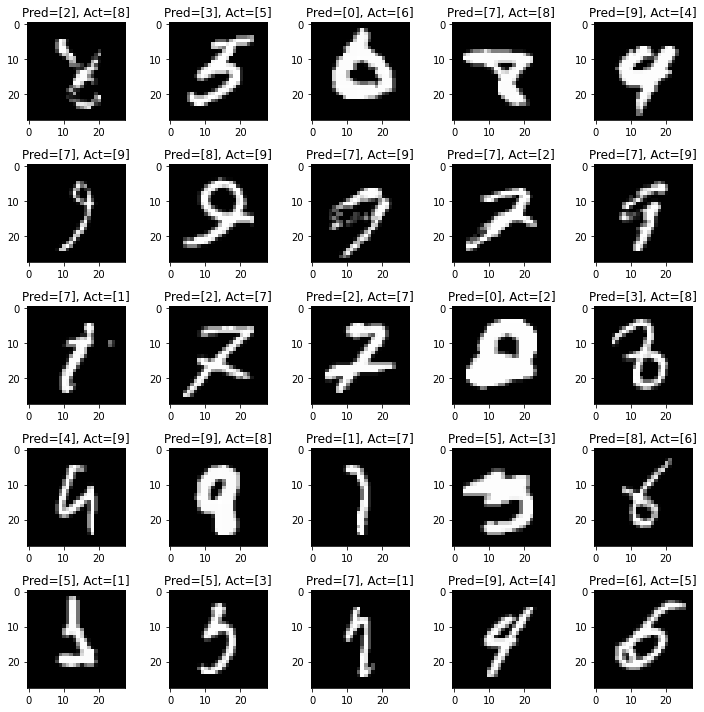

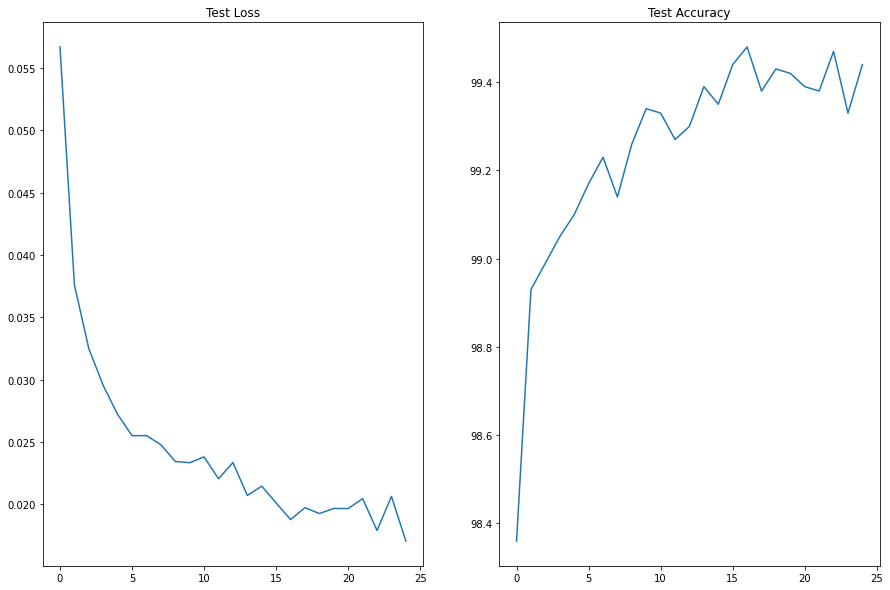

In [9]:
with TrainTestUtils() as utils_obj:
    obj1 = Net(batch_type="GBN")
    device = utils_obj.get_device()
    model =  obj1.to(device)

    utils_obj.display_summary(model, 28)

    utils_obj.train_test_model(model, EPOCHS=EPOCHS, batch_size=GBN_BATCHSIZE)

    gbn_misclassifiedwithoutL1L2.extend(utils_obj.misclassifiedImages)
    utils_obj.plot_misclassified(gbn_misclassifiedwithoutL1L2)

    gbn_test_without_L1L2_Loss.extend(utils_obj.test_losses)
    gbn_test_without_L1L2_acc.extend(utils_obj.test_acc)

    utils_obj.plot_test_loss_acc(gbn_test_without_L1L2_Loss, gbn_test_without_L1L2_acc)

device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
    GhostBatchNorm-3           [-1, 10, 26, 26]              20
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
    GhostBatchNorm-7           [-1, 20, 24, 24]              40
         Dropout2d-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 20, 10, 10]           1,800
             ReLU-12           [-1, 20, 10, 10]               0
   GhostBatchNorm-13           [-1, 20, 10, 10]              40
        Dropout2d-14           [

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/938 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Train Set: Train Loss=0.497113972902298 Batch_id=937 Accuracy=85.09: 100%|██████████| 938/938 [00:20<00:00, 44.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  233

Test set: Average loss: 0.0772, Accuracy: 9767/10000 (97.67%)

EPOCH: 2


Train Set: Train Loss=0.33201563358306885 Batch_id=937 Accuracy=94.92: 100%|██████████| 938/938 [00:20<00:00, 45.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  212

Test set: Average loss: 0.0652, Accuracy: 9788/10000 (97.88%)

EPOCH: 3


Train Set: Train Loss=0.37900620698928833 Batch_id=937 Accuracy=95.63: 100%|██████████| 938/938 [00:21<00:00, 43.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  138

Test set: Average loss: 0.0425, Accuracy: 9862/10000 (98.62%)

EPOCH: 4


Train Set: Train Loss=0.4310840368270874 Batch_id=937 Accuracy=95.70: 100%|██████████| 938/938 [00:20<00:00, 45.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  169

Test set: Average loss: 0.0544, Accuracy: 9831/10000 (98.31%)

EPOCH: 5


Train Set: Train Loss=0.43842658400535583 Batch_id=937 Accuracy=96.14: 100%|██████████| 938/938 [00:20<00:00, 45.29it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  121

Test set: Average loss: 0.0393, Accuracy: 9879/10000 (98.79%)

EPOCH: 6


Train Set: Train Loss=0.3282731771469116 Batch_id=937 Accuracy=96.24: 100%|██████████| 938/938 [00:20<00:00, 45.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  151

Test set: Average loss: 0.0467, Accuracy: 9849/10000 (98.49%)

EPOCH: 7


Train Set: Train Loss=0.6915590167045593 Batch_id=937 Accuracy=96.32: 100%|██████████| 938/938 [00:20<00:00, 45.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  121

Test set: Average loss: 0.0409, Accuracy: 9879/10000 (98.79%)

EPOCH: 8


Train Set: Train Loss=0.4574196934700012 Batch_id=937 Accuracy=96.23: 100%|██████████| 938/938 [00:20<00:00, 45.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  149

Test set: Average loss: 0.0463, Accuracy: 9851/10000 (98.51%)

EPOCH: 9


Train Set: Train Loss=0.29090067744255066 Batch_id=937 Accuracy=96.22: 100%|██████████| 938/938 [00:20<00:00, 45.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  130

Test set: Average loss: 0.0407, Accuracy: 9870/10000 (98.70%)

EPOCH: 10


Train Set: Train Loss=0.28482192754745483 Batch_id=937 Accuracy=96.36: 100%|██████████| 938/938 [00:20<00:00, 45.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  128

Test set: Average loss: 0.0370, Accuracy: 9872/10000 (98.72%)

EPOCH: 11


Train Set: Train Loss=0.27715352177619934 Batch_id=937 Accuracy=96.39: 100%|██████████| 938/938 [00:20<00:00, 45.98it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  145

Test set: Average loss: 0.0490, Accuracy: 9855/10000 (98.55%)

EPOCH: 12


Train Set: Train Loss=0.43718358874320984 Batch_id=937 Accuracy=96.46: 100%|██████████| 938/938 [00:20<00:00, 46.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  108

Test set: Average loss: 0.0349, Accuracy: 9892/10000 (98.92%)

EPOCH: 13


Train Set: Train Loss=0.3177623450756073 Batch_id=937 Accuracy=96.42: 100%|██████████| 938/938 [00:20<00:00, 46.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  113

Test set: Average loss: 0.0353, Accuracy: 9887/10000 (98.87%)

EPOCH: 14


Train Set: Train Loss=0.7927646636962891 Batch_id=937 Accuracy=96.36: 100%|██████████| 938/938 [00:20<00:00, 46.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  131

Test set: Average loss: 0.0418, Accuracy: 9869/10000 (98.69%)

EPOCH: 15


Train Set: Train Loss=0.4964115023612976 Batch_id=937 Accuracy=96.53: 100%|██████████| 938/938 [00:20<00:00, 46.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  118

Test set: Average loss: 0.0362, Accuracy: 9882/10000 (98.82%)

EPOCH: 16


Train Set: Train Loss=0.3322664499282837 Batch_id=937 Accuracy=96.45: 100%|██████████| 938/938 [00:19<00:00, 46.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  121

Test set: Average loss: 0.0411, Accuracy: 9879/10000 (98.79%)

EPOCH: 17


Train Set: Train Loss=0.34041163325309753 Batch_id=937 Accuracy=96.45: 100%|██████████| 938/938 [00:20<00:00, 46.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  104

Test set: Average loss: 0.0358, Accuracy: 9896/10000 (98.96%)

EPOCH: 18


Train Set: Train Loss=0.33103448152542114 Batch_id=937 Accuracy=96.58: 100%|██████████| 938/938 [00:20<00:00, 46.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  138

Test set: Average loss: 0.0450, Accuracy: 9862/10000 (98.62%)

EPOCH: 19


Train Set: Train Loss=0.23759159445762634 Batch_id=937 Accuracy=96.47: 100%|██████████| 938/938 [00:20<00:00, 46.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  121

Test set: Average loss: 0.0383, Accuracy: 9879/10000 (98.79%)

EPOCH: 20


Train Set: Train Loss=0.34326496720314026 Batch_id=937 Accuracy=96.44: 100%|██████████| 938/938 [00:19<00:00, 47.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  139

Test set: Average loss: 0.0445, Accuracy: 9861/10000 (98.61%)

EPOCH: 21


Train Set: Train Loss=0.31050559878349304 Batch_id=937 Accuracy=96.60: 100%|██████████| 938/938 [00:20<00:00, 46.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  159

Test set: Average loss: 0.0463, Accuracy: 9841/10000 (98.41%)

EPOCH: 22


Train Set: Train Loss=0.2221887856721878 Batch_id=937 Accuracy=96.56: 100%|██████████| 938/938 [00:20<00:00, 46.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  122

Test set: Average loss: 0.0393, Accuracy: 9878/10000 (98.78%)

EPOCH: 23


Train Set: Train Loss=0.3646145761013031 Batch_id=937 Accuracy=96.59: 100%|██████████| 938/938 [00:20<00:00, 46.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  134

Test set: Average loss: 0.0430, Accuracy: 9866/10000 (98.66%)

EPOCH: 24


Train Set: Train Loss=0.35076451301574707 Batch_id=937 Accuracy=96.45: 100%|██████████| 938/938 [00:19<00:00, 47.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  146

Test set: Average loss: 0.0436, Accuracy: 9854/10000 (98.54%)

EPOCH: 25


Train Set: Train Loss=0.38585513830184937 Batch_id=937 Accuracy=96.51: 100%|██████████| 938/938 [00:20<00:00, 46.86it/s]


Number of miscalssified Images =  132

Test set: Average loss: 0.0397, Accuracy: 9868/10000 (98.68%)



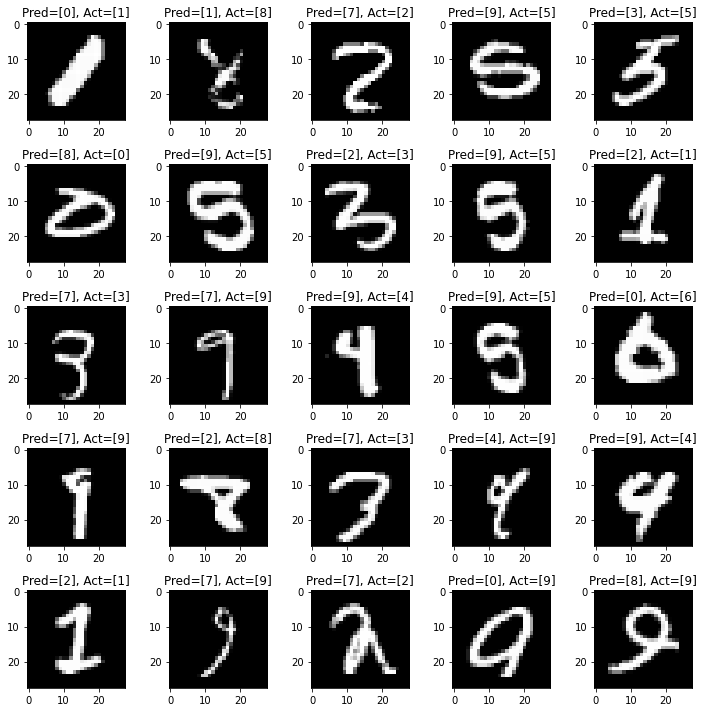

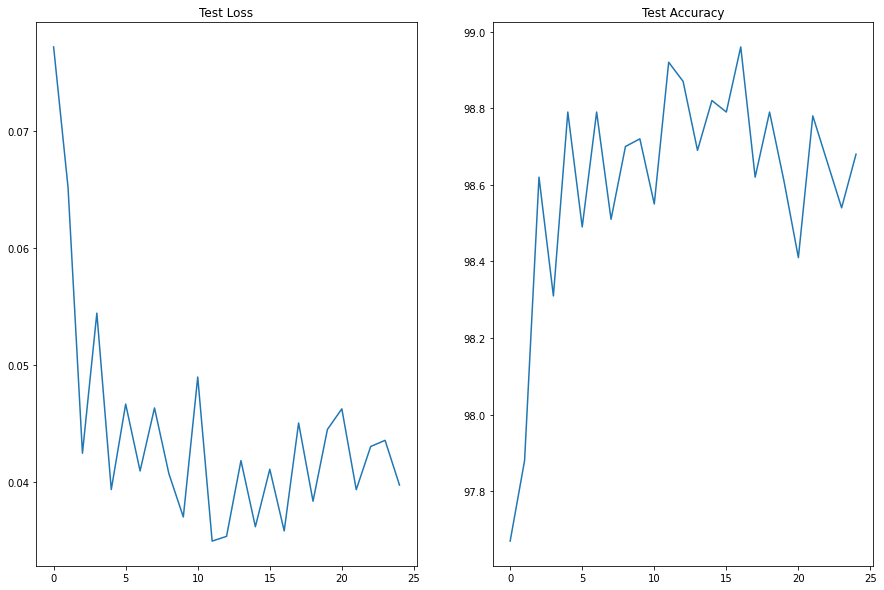

In [10]:
with TrainTestUtils() as utils_obj:
    obj1 = Net(batch_type="GBN")
    device = utils_obj.get_device()
    model =  obj1.to(device)

    utils_obj.display_summary(model, 28)

    utils_obj.train_test_model(model, EPOCHS=EPOCHS, batch_size=GBN_BATCHSIZE, l1_factor=0.0005)

    gbn_misclassifiedL1.extend(utils_obj.misclassifiedImages)
    utils_obj.plot_misclassified(gbn_misclassifiedL1)

    gbn_test_with_L1_Loss.extend(utils_obj.test_losses)
    gbn_test_with_L1_acc.extend(utils_obj.test_acc)

    utils_obj.plot_test_loss_acc(gbn_test_with_L1_Loss, gbn_test_with_L1_acc)

device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
    GhostBatchNorm-3           [-1, 10, 26, 26]              20
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
    GhostBatchNorm-7           [-1, 20, 24, 24]              40
         Dropout2d-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 20, 10, 10]           1,800
             ReLU-12           [-1, 20, 10, 10]               0
   GhostBatchNorm-13           [-1, 20, 10, 10]              40
        Dropout2d-14           [

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/938 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


Train Set: Train Loss=0.2932983636856079 Batch_id=937 Accuracy=85.08: 100%|██████████| 938/938 [00:18<00:00, 51.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  193

Test set: Average loss: 0.0785, Accuracy: 9807/10000 (98.07%)

EPOCH: 2


Train Set: Train Loss=0.18261192739009857 Batch_id=937 Accuracy=95.06: 100%|██████████| 938/938 [00:18<00:00, 50.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  165

Test set: Average loss: 0.0634, Accuracy: 9835/10000 (98.35%)

EPOCH: 3


Train Set: Train Loss=0.14260601997375488 Batch_id=937 Accuracy=95.80: 100%|██████████| 938/938 [00:18<00:00, 51.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  167

Test set: Average loss: 0.0660, Accuracy: 9833/10000 (98.33%)

EPOCH: 4


Train Set: Train Loss=0.1549513190984726 Batch_id=937 Accuracy=95.81: 100%|██████████| 938/938 [00:18<00:00, 51.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  199

Test set: Average loss: 0.0696, Accuracy: 9801/10000 (98.01%)

EPOCH: 5


Train Set: Train Loss=0.16457171738147736 Batch_id=937 Accuracy=96.16: 100%|██████████| 938/938 [00:18<00:00, 49.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  127

Test set: Average loss: 0.0529, Accuracy: 9873/10000 (98.73%)

EPOCH: 6


Train Set: Train Loss=0.1944628804922104 Batch_id=937 Accuracy=96.19: 100%|██████████| 938/938 [00:18<00:00, 50.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  121

Test set: Average loss: 0.0492, Accuracy: 9879/10000 (98.79%)

EPOCH: 7


Train Set: Train Loss=0.35787197947502136 Batch_id=937 Accuracy=96.27: 100%|██████████| 938/938 [00:18<00:00, 50.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  124

Test set: Average loss: 0.0563, Accuracy: 9876/10000 (98.76%)

EPOCH: 8


Train Set: Train Loss=0.19401974976062775 Batch_id=937 Accuracy=96.19: 100%|██████████| 938/938 [00:18<00:00, 50.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  157

Test set: Average loss: 0.0596, Accuracy: 9843/10000 (98.43%)

EPOCH: 9


Train Set: Train Loss=0.14863531291484833 Batch_id=937 Accuracy=96.30: 100%|██████████| 938/938 [00:18<00:00, 50.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  156

Test set: Average loss: 0.0557, Accuracy: 9844/10000 (98.44%)

EPOCH: 10


Train Set: Train Loss=0.1406843066215515 Batch_id=937 Accuracy=96.31: 100%|██████████| 938/938 [00:18<00:00, 51.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  143

Test set: Average loss: 0.0533, Accuracy: 9857/10000 (98.57%)

EPOCH: 11


Train Set: Train Loss=0.14922472834587097 Batch_id=937 Accuracy=96.31: 100%|██████████| 938/938 [00:18<00:00, 51.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  150

Test set: Average loss: 0.0617, Accuracy: 9850/10000 (98.50%)

EPOCH: 12


Train Set: Train Loss=0.3359489142894745 Batch_id=937 Accuracy=96.38: 100%|██████████| 938/938 [00:18<00:00, 50.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  116

Test set: Average loss: 0.0442, Accuracy: 9884/10000 (98.84%)

EPOCH: 13


Train Set: Train Loss=0.14945362508296967 Batch_id=937 Accuracy=96.43: 100%|██████████| 938/938 [00:18<00:00, 50.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  124

Test set: Average loss: 0.0497, Accuracy: 9876/10000 (98.76%)

EPOCH: 14


Train Set: Train Loss=0.5254120826721191 Batch_id=937 Accuracy=96.43: 100%|██████████| 938/938 [00:18<00:00, 50.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  146

Test set: Average loss: 0.0573, Accuracy: 9854/10000 (98.54%)

EPOCH: 15


Train Set: Train Loss=0.16767518222332 Batch_id=937 Accuracy=96.33: 100%|██████████| 938/938 [00:18<00:00, 51.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  125

Test set: Average loss: 0.0542, Accuracy: 9875/10000 (98.75%)

EPOCH: 16


Train Set: Train Loss=0.1783054620027542 Batch_id=937 Accuracy=96.42: 100%|██████████| 938/938 [00:18<00:00, 50.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  134

Test set: Average loss: 0.0540, Accuracy: 9866/10000 (98.66%)

EPOCH: 17


Train Set: Train Loss=0.2143602818250656 Batch_id=937 Accuracy=96.44: 100%|██████████| 938/938 [00:18<00:00, 49.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  150

Test set: Average loss: 0.0600, Accuracy: 9850/10000 (98.50%)

EPOCH: 18


Train Set: Train Loss=0.08135787397623062 Batch_id=937 Accuracy=96.38: 100%|██████████| 938/938 [00:18<00:00, 50.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  131

Test set: Average loss: 0.0475, Accuracy: 9869/10000 (98.69%)

EPOCH: 19


Train Set: Train Loss=0.0998540148139 Batch_id=937 Accuracy=96.44: 100%|██████████| 938/938 [00:18<00:00, 50.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  136

Test set: Average loss: 0.0531, Accuracy: 9864/10000 (98.64%)

EPOCH: 20


Train Set: Train Loss=0.19125354290008545 Batch_id=937 Accuracy=96.31: 100%|██████████| 938/938 [00:18<00:00, 49.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  113

Test set: Average loss: 0.0486, Accuracy: 9887/10000 (98.87%)

EPOCH: 21


Train Set: Train Loss=0.18226760625839233 Batch_id=937 Accuracy=96.38: 100%|██████████| 938/938 [00:18<00:00, 50.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  143

Test set: Average loss: 0.0542, Accuracy: 9857/10000 (98.57%)

EPOCH: 22


Train Set: Train Loss=0.055694855749607086 Batch_id=937 Accuracy=96.41: 100%|██████████| 938/938 [00:18<00:00, 50.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  135

Test set: Average loss: 0.0508, Accuracy: 9865/10000 (98.65%)

EPOCH: 23


Train Set: Train Loss=0.2023783177137375 Batch_id=937 Accuracy=96.45: 100%|██████████| 938/938 [00:18<00:00, 50.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  127

Test set: Average loss: 0.0506, Accuracy: 9873/10000 (98.73%)

EPOCH: 24


Train Set: Train Loss=0.17941026389598846 Batch_id=937 Accuracy=96.50: 100%|██████████| 938/938 [00:18<00:00, 50.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  166

Test set: Average loss: 0.0609, Accuracy: 9834/10000 (98.34%)

EPOCH: 25


Train Set: Train Loss=0.23820587992668152 Batch_id=937 Accuracy=96.42: 100%|██████████| 938/938 [00:18<00:00, 50.26it/s]


Number of miscalssified Images =  108

Test set: Average loss: 0.0435, Accuracy: 9892/10000 (98.92%)



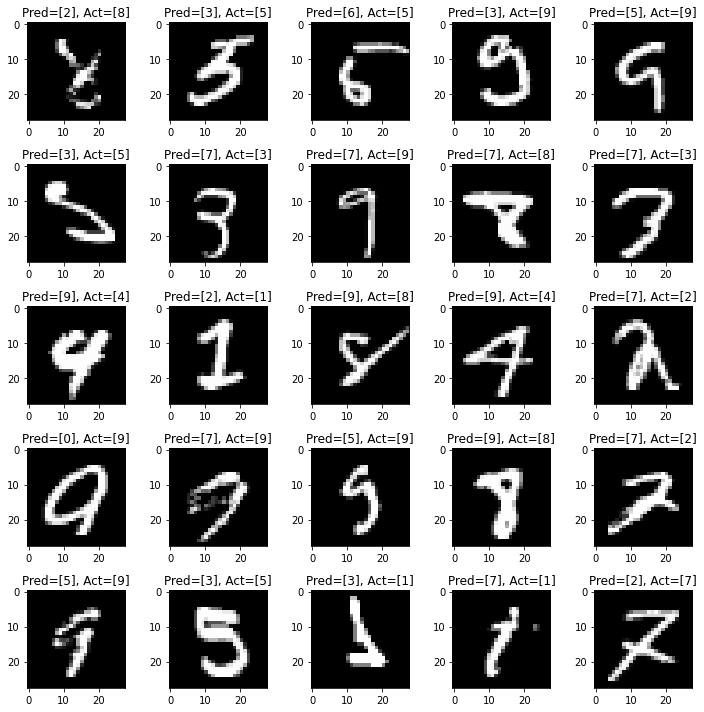

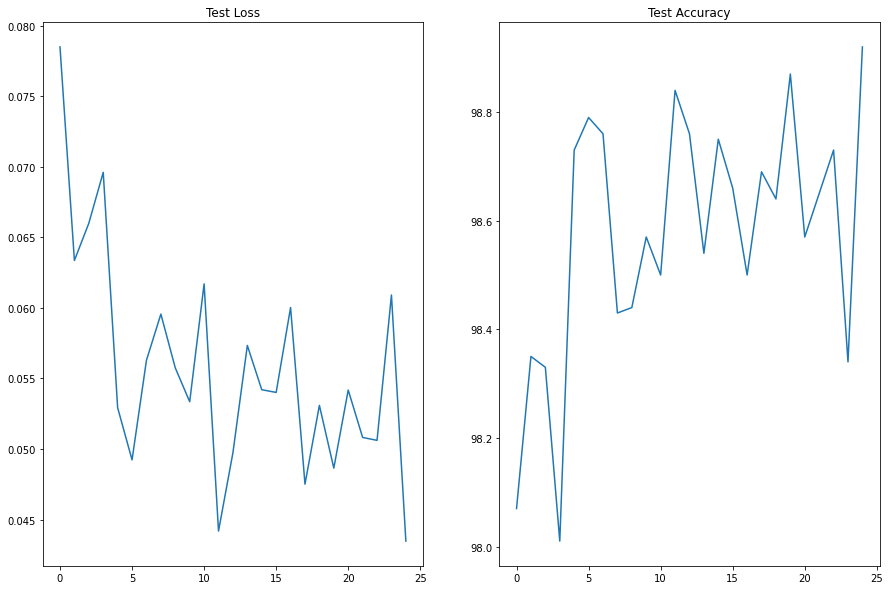

In [11]:
with TrainTestUtils() as utils_obj:
    obj1 = Net(batch_type="GBN")
    device = utils_obj.get_device()
    model =  obj1.to(device)
    l2_regulizer  =  utils_obj.apply_l2_regularizer(model, 0.005)

    utils_obj.display_summary(model, 28)

    utils_obj.train_test_model(model, EPOCHS=EPOCHS, batch_size=GBN_BATCHSIZE, optimizer=l2_regulizer)

    gbn_misclassifiedL2.extend(utils_obj.misclassifiedImages)
    utils_obj.plot_misclassified(gbn_misclassifiedL2)

    gbn_test_with_L2_Loss.extend(utils_obj.test_losses)
    gbn_test_with_L2_acc.extend(utils_obj.test_acc)

    utils_obj.plot_test_loss_acc(gbn_test_with_L2_Loss, gbn_test_with_L2_acc)

device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
    GhostBatchNorm-3           [-1, 10, 26, 26]              20
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
    GhostBatchNorm-7           [-1, 20, 24, 24]              40
         Dropout2d-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 20, 10, 10]           1,800
             ReLU-12           [-1, 20, 10, 10]               0
   GhostBatchNorm-13           [-1, 20, 10, 10]              40
        Dropout2d-14           [

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/938 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Train Set: Train Loss=0.5068329572677612 Batch_id=937 Accuracy=84.98: 100%|██████████| 938/938 [00:20<00:00, 45.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  197

Test set: Average loss: 0.0899, Accuracy: 9803/10000 (98.03%)

EPOCH: 2


Train Set: Train Loss=0.4105229377746582 Batch_id=937 Accuracy=94.30: 100%|██████████| 938/938 [00:20<00:00, 45.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  210

Test set: Average loss: 0.0835, Accuracy: 9790/10000 (97.90%)

EPOCH: 3


Train Set: Train Loss=0.30341506004333496 Batch_id=937 Accuracy=94.74: 100%|██████████| 938/938 [00:20<00:00, 45.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  187

Test set: Average loss: 0.0767, Accuracy: 9813/10000 (98.13%)

EPOCH: 4


Train Set: Train Loss=0.3144228458404541 Batch_id=937 Accuracy=94.75: 100%|██████████| 938/938 [00:20<00:00, 45.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  214

Test set: Average loss: 0.0786, Accuracy: 9786/10000 (97.86%)

EPOCH: 5


Train Set: Train Loss=0.4191146790981293 Batch_id=937 Accuracy=95.08: 100%|██████████| 938/938 [00:21<00:00, 44.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  184

Test set: Average loss: 0.0702, Accuracy: 9816/10000 (98.16%)

EPOCH: 6


Train Set: Train Loss=0.3824024796485901 Batch_id=937 Accuracy=95.03: 100%|██████████| 938/938 [00:20<00:00, 45.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  190

Test set: Average loss: 0.0746, Accuracy: 9810/10000 (98.10%)

EPOCH: 7


Train Set: Train Loss=0.654283881187439 Batch_id=937 Accuracy=95.13: 100%|██████████| 938/938 [00:20<00:00, 45.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  184

Test set: Average loss: 0.0791, Accuracy: 9816/10000 (98.16%)

EPOCH: 8


Train Set: Train Loss=0.40538716316223145 Batch_id=937 Accuracy=95.13: 100%|██████████| 938/938 [00:20<00:00, 45.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  258

Test set: Average loss: 0.1008, Accuracy: 9742/10000 (97.42%)

EPOCH: 9


Train Set: Train Loss=0.48600226640701294 Batch_id=937 Accuracy=95.15: 100%|██████████| 938/938 [00:20<00:00, 45.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  173

Test set: Average loss: 0.0695, Accuracy: 9827/10000 (98.27%)

EPOCH: 10


Train Set: Train Loss=0.4446059763431549 Batch_id=937 Accuracy=95.14: 100%|██████████| 938/938 [00:20<00:00, 44.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  175

Test set: Average loss: 0.0728, Accuracy: 9825/10000 (98.25%)

EPOCH: 11


Train Set: Train Loss=0.41801345348358154 Batch_id=937 Accuracy=95.22: 100%|██████████| 938/938 [00:20<00:00, 45.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  219

Test set: Average loss: 0.0887, Accuracy: 9781/10000 (97.81%)

EPOCH: 12


Train Set: Train Loss=0.42679110169410706 Batch_id=937 Accuracy=95.32: 100%|██████████| 938/938 [00:20<00:00, 45.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  157

Test set: Average loss: 0.0660, Accuracy: 9843/10000 (98.43%)

EPOCH: 13


Train Set: Train Loss=0.3600558936595917 Batch_id=937 Accuracy=95.20: 100%|██████████| 938/938 [00:20<00:00, 45.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  209

Test set: Average loss: 0.0831, Accuracy: 9791/10000 (97.91%)

EPOCH: 14


Train Set: Train Loss=0.9258089065551758 Batch_id=937 Accuracy=95.29: 100%|██████████| 938/938 [00:20<00:00, 45.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  160

Test set: Average loss: 0.0753, Accuracy: 9840/10000 (98.40%)

EPOCH: 15


Train Set: Train Loss=0.41767042875289917 Batch_id=937 Accuracy=95.28: 100%|██████████| 938/938 [00:20<00:00, 45.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  128

Test set: Average loss: 0.0612, Accuracy: 9872/10000 (98.72%)

EPOCH: 16


Train Set: Train Loss=0.3479292094707489 Batch_id=937 Accuracy=95.33: 100%|██████████| 938/938 [00:20<00:00, 45.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  189

Test set: Average loss: 0.0731, Accuracy: 9811/10000 (98.11%)

EPOCH: 17


Train Set: Train Loss=0.41340288519859314 Batch_id=937 Accuracy=95.26: 100%|██████████| 938/938 [00:20<00:00, 45.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  166

Test set: Average loss: 0.0693, Accuracy: 9834/10000 (98.34%)

EPOCH: 18


Train Set: Train Loss=0.3842569589614868 Batch_id=937 Accuracy=95.31: 100%|██████████| 938/938 [00:20<00:00, 45.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  174

Test set: Average loss: 0.0670, Accuracy: 9826/10000 (98.26%)

EPOCH: 19


Train Set: Train Loss=0.34725290536880493 Batch_id=937 Accuracy=95.30: 100%|██████████| 938/938 [00:20<00:00, 46.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  193

Test set: Average loss: 0.0774, Accuracy: 9807/10000 (98.07%)

EPOCH: 20


Train Set: Train Loss=0.3733757734298706 Batch_id=937 Accuracy=95.24: 100%|██████████| 938/938 [00:20<00:00, 45.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  181

Test set: Average loss: 0.0682, Accuracy: 9819/10000 (98.19%)

EPOCH: 21


Train Set: Train Loss=0.38562512397766113 Batch_id=937 Accuracy=95.13: 100%|██████████| 938/938 [00:20<00:00, 45.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  158

Test set: Average loss: 0.0635, Accuracy: 9842/10000 (98.42%)

EPOCH: 22


Train Set: Train Loss=0.2947283983230591 Batch_id=937 Accuracy=95.20: 100%|██████████| 938/938 [00:20<00:00, 46.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  184

Test set: Average loss: 0.0676, Accuracy: 9816/10000 (98.16%)

EPOCH: 23


Train Set: Train Loss=0.37242379784584045 Batch_id=937 Accuracy=95.39: 100%|██████████| 938/938 [00:20<00:00, 46.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  184

Test set: Average loss: 0.0784, Accuracy: 9816/10000 (98.16%)

EPOCH: 24


Train Set: Train Loss=0.4153428375720978 Batch_id=937 Accuracy=95.25: 100%|██████████| 938/938 [00:20<00:00, 45.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  144

Test set: Average loss: 0.0621, Accuracy: 9856/10000 (98.56%)

EPOCH: 25


Train Set: Train Loss=0.5119246244430542 Batch_id=937 Accuracy=95.36: 100%|██████████| 938/938 [00:20<00:00, 45.34it/s]


Number of miscalssified Images =  182

Test set: Average loss: 0.0713, Accuracy: 9818/10000 (98.18%)



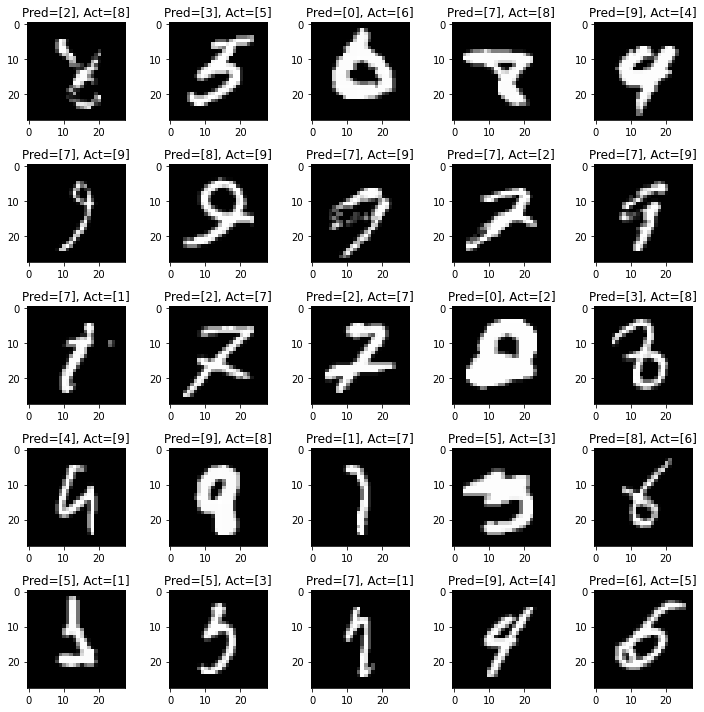

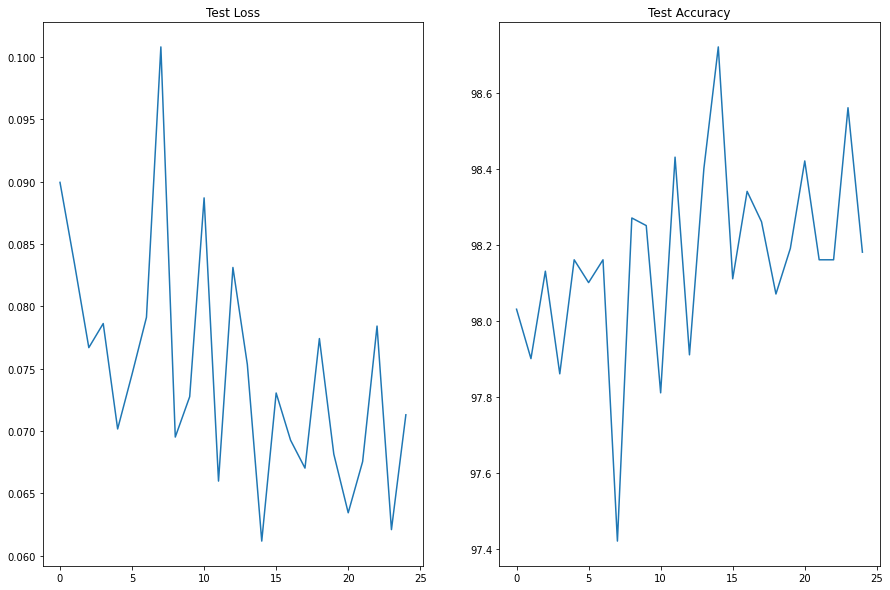

In [12]:
with TrainTestUtils() as utils_obj:
    obj1 = Net(batch_type="GBN")
    device = utils_obj.get_device()
    model =  obj1.to(device)
    l2_regulizer  =  utils_obj.apply_l2_regularizer(model, 0.005)

    utils_obj.display_summary(model, 28)

    utils_obj.train_test_model(model, EPOCHS=EPOCHS, batch_size=GBN_BATCHSIZE, l1_factor=0.0005, optimizer=l2_regulizer)

    gbn_misclassifiedL1L2.extend(utils_obj.misclassifiedImages)
    utils_obj.plot_misclassified(gbn_misclassifiedwithoutL1L2)

    gbn_test_with_L1L2_Loss.extend(utils_obj.test_losses)
    gbn_test_with_L1L2_acc.extend(utils_obj.test_acc)

    utils_obj.plot_test_loss_acc(gbn_test_with_L1L2_Loss, gbn_test_with_L1L2_acc)

device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
       BatchNorm2d-7           [-1, 20, 24, 24]              40
         Dropout2d-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 20, 10, 10]           1,800
             ReLU-12           [-1, 20, 10, 10]               0
      BatchNorm2d-13           [-1, 20, 10, 10]              40
        Dropout2d-14           [

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/1875 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


Train Set: Train Loss=0.16042648255825043 Batch_id=1874 Accuracy=88.62: 100%|██████████| 1875/1875 [00:26<00:00, 71.48it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  170

Test set: Average loss: 0.0564, Accuracy: 9830/10000 (98.30%)

EPOCH: 2


Train Set: Train Loss=0.041793957352638245 Batch_id=1874 Accuracy=95.89: 100%|██████████| 1875/1875 [00:26<00:00, 70.34it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  125

Test set: Average loss: 0.0409, Accuracy: 9875/10000 (98.75%)

EPOCH: 3


Train Set: Train Loss=0.026374459266662598 Batch_id=1874 Accuracy=96.59: 100%|██████████| 1875/1875 [00:25<00:00, 72.61it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  108

Test set: Average loss: 0.0329, Accuracy: 9892/10000 (98.92%)

EPOCH: 4


Train Set: Train Loss=0.14647670090198517 Batch_id=1874 Accuracy=97.01: 100%|██████████| 1875/1875 [00:25<00:00, 72.27it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  104

Test set: Average loss: 0.0310, Accuracy: 9896/10000 (98.96%)

EPOCH: 5


Train Set: Train Loss=0.11452385783195496 Batch_id=1874 Accuracy=97.27: 100%|██████████| 1875/1875 [00:25<00:00, 72.29it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  85

Test set: Average loss: 0.0266, Accuracy: 9915/10000 (99.15%)

EPOCH: 6


Train Set: Train Loss=0.016972288489341736 Batch_id=1874 Accuracy=97.36: 100%|██████████| 1875/1875 [00:25<00:00, 73.48it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  90

Test set: Average loss: 0.0284, Accuracy: 9910/10000 (99.10%)

EPOCH: 7


Train Set: Train Loss=0.18957599997520447 Batch_id=1874 Accuracy=97.46: 100%|██████████| 1875/1875 [00:25<00:00, 72.25it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  87

Test set: Average loss: 0.0285, Accuracy: 9913/10000 (99.13%)

EPOCH: 8


Train Set: Train Loss=0.027357548475265503 Batch_id=1874 Accuracy=97.50: 100%|██████████| 1875/1875 [00:25<00:00, 72.56it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  81

Test set: Average loss: 0.0240, Accuracy: 9919/10000 (99.19%)

EPOCH: 9


Train Set: Train Loss=0.03906188905239105 Batch_id=1874 Accuracy=97.71: 100%|██████████| 1875/1875 [00:26<00:00, 70.97it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  68

Test set: Average loss: 0.0231, Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Train Set: Train Loss=0.007922336459159851 Batch_id=1874 Accuracy=97.78: 100%|██████████| 1875/1875 [00:26<00:00, 70.29it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  67

Test set: Average loss: 0.0227, Accuracy: 9933/10000 (99.33%)

EPOCH: 11


Train Set: Train Loss=0.009435966610908508 Batch_id=1874 Accuracy=97.81: 100%|██████████| 1875/1875 [00:26<00:00, 71.42it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  78

Test set: Average loss: 0.0251, Accuracy: 9922/10000 (99.22%)

EPOCH: 12


Train Set: Train Loss=0.05222359299659729 Batch_id=1874 Accuracy=97.91: 100%|██████████| 1875/1875 [00:26<00:00, 70.78it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  77

Test set: Average loss: 0.0235, Accuracy: 9923/10000 (99.23%)

EPOCH: 13


Train Set: Train Loss=0.02296672761440277 Batch_id=1874 Accuracy=98.02: 100%|██████████| 1875/1875 [00:26<00:00, 70.77it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  74

Test set: Average loss: 0.0229, Accuracy: 9926/10000 (99.26%)

EPOCH: 14


Train Set: Train Loss=0.14535319805145264 Batch_id=1874 Accuracy=98.07: 100%|██████████| 1875/1875 [00:26<00:00, 70.48it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  73

Test set: Average loss: 0.0212, Accuracy: 9927/10000 (99.27%)

EPOCH: 15


Train Set: Train Loss=0.010927528142929077 Batch_id=1874 Accuracy=97.98: 100%|██████████| 1875/1875 [00:26<00:00, 71.96it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  70

Test set: Average loss: 0.0234, Accuracy: 9930/10000 (99.30%)

EPOCH: 16


Train Set: Train Loss=0.011706218123435974 Batch_id=1874 Accuracy=98.06: 100%|██████████| 1875/1875 [00:26<00:00, 70.40it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  71

Test set: Average loss: 0.0233, Accuracy: 9929/10000 (99.29%)

EPOCH: 17


Train Set: Train Loss=0.022177204489707947 Batch_id=1874 Accuracy=98.08: 100%|██████████| 1875/1875 [00:26<00:00, 71.52it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  68

Test set: Average loss: 0.0214, Accuracy: 9932/10000 (99.32%)

EPOCH: 18


Train Set: Train Loss=0.047580018639564514 Batch_id=1874 Accuracy=98.17: 100%|██████████| 1875/1875 [00:26<00:00, 71.38it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  66

Test set: Average loss: 0.0212, Accuracy: 9934/10000 (99.34%)

EPOCH: 19


Train Set: Train Loss=0.0013046562671661377 Batch_id=1874 Accuracy=98.25: 100%|██████████| 1875/1875 [00:26<00:00, 71.39it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  65

Test set: Average loss: 0.0205, Accuracy: 9935/10000 (99.35%)

EPOCH: 20


Train Set: Train Loss=0.029275164008140564 Batch_id=1874 Accuracy=98.15: 100%|██████████| 1875/1875 [00:26<00:00, 70.85it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  64

Test set: Average loss: 0.0204, Accuracy: 9936/10000 (99.36%)

EPOCH: 21


Train Set: Train Loss=0.12363919615745544 Batch_id=1874 Accuracy=98.20: 100%|██████████| 1875/1875 [00:26<00:00, 71.00it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  74

Test set: Average loss: 0.0231, Accuracy: 9926/10000 (99.26%)

EPOCH: 22


Train Set: Train Loss=0.17397648096084595 Batch_id=1874 Accuracy=98.18: 100%|██████████| 1875/1875 [00:26<00:00, 71.39it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  64

Test set: Average loss: 0.0213, Accuracy: 9936/10000 (99.36%)

EPOCH: 23


Train Set: Train Loss=0.006443008780479431 Batch_id=1874 Accuracy=98.25: 100%|██████████| 1875/1875 [00:26<00:00, 70.71it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  67

Test set: Average loss: 0.0214, Accuracy: 9933/10000 (99.33%)

EPOCH: 24


Train Set: Train Loss=0.07461927086114883 Batch_id=1874 Accuracy=98.21: 100%|██████████| 1875/1875 [00:26<00:00, 70.18it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  66

Test set: Average loss: 0.0206, Accuracy: 9934/10000 (99.34%)

EPOCH: 25


Train Set: Train Loss=0.011182814836502075 Batch_id=1874 Accuracy=98.37: 100%|██████████| 1875/1875 [00:26<00:00, 71.33it/s]


Number of miscalssified Images =  59

Test set: Average loss: 0.0188, Accuracy: 9941/10000 (99.41%)



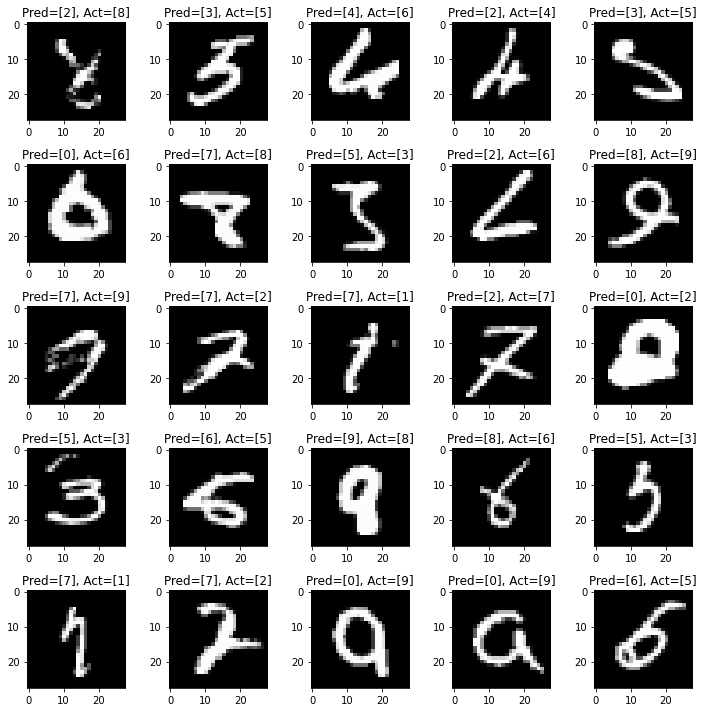

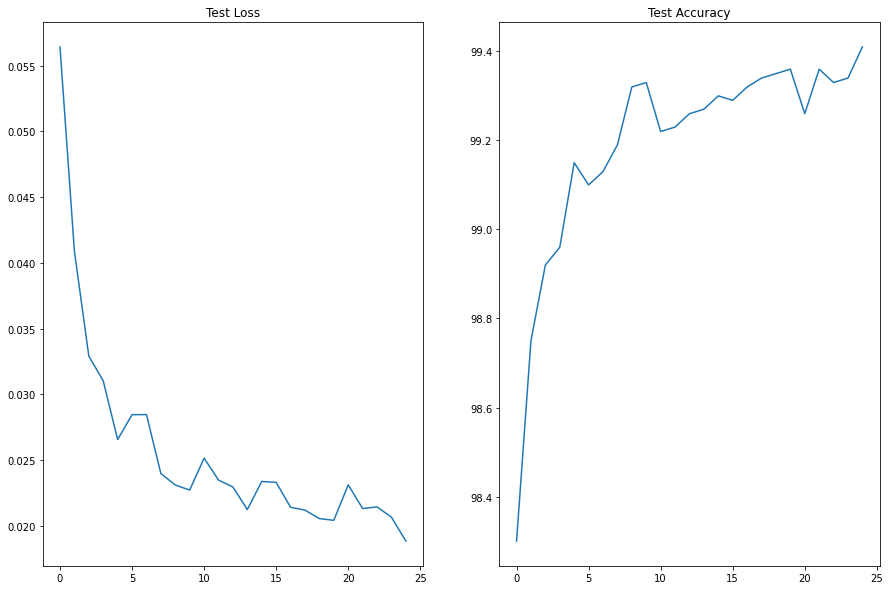

In [13]:
with TrainTestUtils() as utils_obj:
    obj1 = Net()
    device = utils_obj.get_device()
    model =  obj1.to(device)

    utils_obj.display_summary(model, 28)

    utils_obj.train_test_model(model, EPOCHS=EPOCHS, batch_size=BN_BATCHSIZE)

    bn_misclassifiedwithoutL1L2.extend(utils_obj.misclassifiedImages)
    utils_obj.plot_misclassified(bn_misclassifiedwithoutL1L2)

    bn_test_without_L1L2_Loss.extend(utils_obj.test_losses)
    bn_test_without_L1L2_acc.extend(utils_obj.test_acc)

    utils_obj.plot_test_loss_acc(bn_test_without_L1L2_Loss, bn_test_without_L1L2_acc)

device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
       BatchNorm2d-7           [-1, 20, 24, 24]              40
         Dropout2d-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 20, 10, 10]           1,800
             ReLU-12           [-1, 20, 10, 10]               0
      BatchNorm2d-13           [-1, 20, 10, 10]              40
        Dropout2d-14           [

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/1875 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


Train Set: Train Loss=0.13594189286231995 Batch_id=1874 Accuracy=88.28: 100%|██████████| 1875/1875 [00:27<00:00, 69.28it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  181

Test set: Average loss: 0.0761, Accuracy: 9819/10000 (98.19%)

EPOCH: 2


Train Set: Train Loss=0.175789475440979 Batch_id=1874 Accuracy=94.83: 100%|██████████| 1875/1875 [00:27<00:00, 67.00it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  169

Test set: Average loss: 0.0712, Accuracy: 9831/10000 (98.31%)

EPOCH: 3


Train Set: Train Loss=0.11849542707204819 Batch_id=1874 Accuracy=95.30: 100%|██████████| 1875/1875 [00:27<00:00, 69.14it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  141

Test set: Average loss: 0.0581, Accuracy: 9859/10000 (98.59%)

EPOCH: 4


Train Set: Train Loss=0.14019657671451569 Batch_id=1874 Accuracy=95.39: 100%|██████████| 1875/1875 [00:27<00:00, 68.26it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  187

Test set: Average loss: 0.0704, Accuracy: 9813/10000 (98.13%)

EPOCH: 5


Train Set: Train Loss=0.09158685058355331 Batch_id=1874 Accuracy=95.51: 100%|██████████| 1875/1875 [00:26<00:00, 70.06it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  138

Test set: Average loss: 0.0576, Accuracy: 9862/10000 (98.62%)

EPOCH: 6


Train Set: Train Loss=0.09871379286050797 Batch_id=1874 Accuracy=95.62: 100%|██████████| 1875/1875 [00:26<00:00, 70.01it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  141

Test set: Average loss: 0.0562, Accuracy: 9859/10000 (98.59%)

EPOCH: 7


Train Set: Train Loss=0.30068403482437134 Batch_id=1874 Accuracy=95.65: 100%|██████████| 1875/1875 [00:27<00:00, 67.80it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  159

Test set: Average loss: 0.0647, Accuracy: 9841/10000 (98.41%)

EPOCH: 8


Train Set: Train Loss=0.18156763911247253 Batch_id=1874 Accuracy=95.75: 100%|██████████| 1875/1875 [00:27<00:00, 68.81it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  154

Test set: Average loss: 0.0609, Accuracy: 9846/10000 (98.46%)

EPOCH: 9


Train Set: Train Loss=0.1777094155550003 Batch_id=1874 Accuracy=95.86: 100%|██████████| 1875/1875 [00:27<00:00, 69.01it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  154

Test set: Average loss: 0.0570, Accuracy: 9846/10000 (98.46%)

EPOCH: 10


Train Set: Train Loss=0.10825767368078232 Batch_id=1874 Accuracy=95.77: 100%|██████████| 1875/1875 [00:26<00:00, 72.09it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  184

Test set: Average loss: 0.0849, Accuracy: 9816/10000 (98.16%)

EPOCH: 11


Train Set: Train Loss=0.12729300558567047 Batch_id=1874 Accuracy=95.80: 100%|██████████| 1875/1875 [00:24<00:00, 75.42it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  142

Test set: Average loss: 0.0548, Accuracy: 9858/10000 (98.58%)

EPOCH: 12


Train Set: Train Loss=0.1294715702533722 Batch_id=1874 Accuracy=95.85: 100%|██████████| 1875/1875 [00:24<00:00, 75.96it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  189

Test set: Average loss: 0.0680, Accuracy: 9811/10000 (98.11%)

EPOCH: 13


Train Set: Train Loss=0.2236248254776001 Batch_id=1874 Accuracy=95.94: 100%|██████████| 1875/1875 [00:25<00:00, 74.12it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  150

Test set: Average loss: 0.0621, Accuracy: 9850/10000 (98.50%)

EPOCH: 14


Train Set: Train Loss=0.2357640266418457 Batch_id=1874 Accuracy=95.84: 100%|██████████| 1875/1875 [00:25<00:00, 74.19it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  184

Test set: Average loss: 0.0778, Accuracy: 9816/10000 (98.16%)

EPOCH: 15


Train Set: Train Loss=0.15278589725494385 Batch_id=1874 Accuracy=95.78: 100%|██████████| 1875/1875 [00:24<00:00, 77.83it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  160

Test set: Average loss: 0.0581, Accuracy: 9840/10000 (98.40%)

EPOCH: 16


Train Set: Train Loss=0.15296049416065216 Batch_id=1874 Accuracy=95.95: 100%|██████████| 1875/1875 [00:24<00:00, 75.22it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  121

Test set: Average loss: 0.0553, Accuracy: 9879/10000 (98.79%)

EPOCH: 17


Train Set: Train Loss=0.0958837941288948 Batch_id=1874 Accuracy=95.80: 100%|██████████| 1875/1875 [00:24<00:00, 75.56it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  140

Test set: Average loss: 0.0623, Accuracy: 9860/10000 (98.60%)

EPOCH: 18


Train Set: Train Loss=0.1399279236793518 Batch_id=1874 Accuracy=95.85: 100%|██████████| 1875/1875 [00:24<00:00, 75.49it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  157

Test set: Average loss: 0.0587, Accuracy: 9843/10000 (98.43%)

EPOCH: 19


Train Set: Train Loss=0.09618674963712692 Batch_id=1874 Accuracy=95.88: 100%|██████████| 1875/1875 [00:24<00:00, 75.63it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  149

Test set: Average loss: 0.0556, Accuracy: 9851/10000 (98.51%)

EPOCH: 20


Train Set: Train Loss=0.09953978657722473 Batch_id=1874 Accuracy=95.75: 100%|██████████| 1875/1875 [00:24<00:00, 76.53it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  140

Test set: Average loss: 0.0539, Accuracy: 9860/10000 (98.60%)

EPOCH: 21


Train Set: Train Loss=0.1852979063987732 Batch_id=1874 Accuracy=95.79: 100%|██████████| 1875/1875 [00:24<00:00, 77.81it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  132

Test set: Average loss: 0.0510, Accuracy: 9868/10000 (98.68%)

EPOCH: 22


Train Set: Train Loss=0.1611437350511551 Batch_id=1874 Accuracy=95.86: 100%|██████████| 1875/1875 [00:24<00:00, 76.99it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  238

Test set: Average loss: 0.0829, Accuracy: 9762/10000 (97.62%)

EPOCH: 23


Train Set: Train Loss=0.1298542320728302 Batch_id=1874 Accuracy=95.94: 100%|██████████| 1875/1875 [00:23<00:00, 78.75it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  117

Test set: Average loss: 0.0493, Accuracy: 9883/10000 (98.83%)

EPOCH: 24


Train Set: Train Loss=0.25185805559158325 Batch_id=1874 Accuracy=95.91: 100%|██████████| 1875/1875 [00:23<00:00, 79.09it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  163

Test set: Average loss: 0.0588, Accuracy: 9837/10000 (98.37%)

EPOCH: 25


Train Set: Train Loss=0.10698113590478897 Batch_id=1874 Accuracy=95.97: 100%|██████████| 1875/1875 [00:24<00:00, 77.62it/s]


Number of miscalssified Images =  187

Test set: Average loss: 0.0665, Accuracy: 9813/10000 (98.13%)



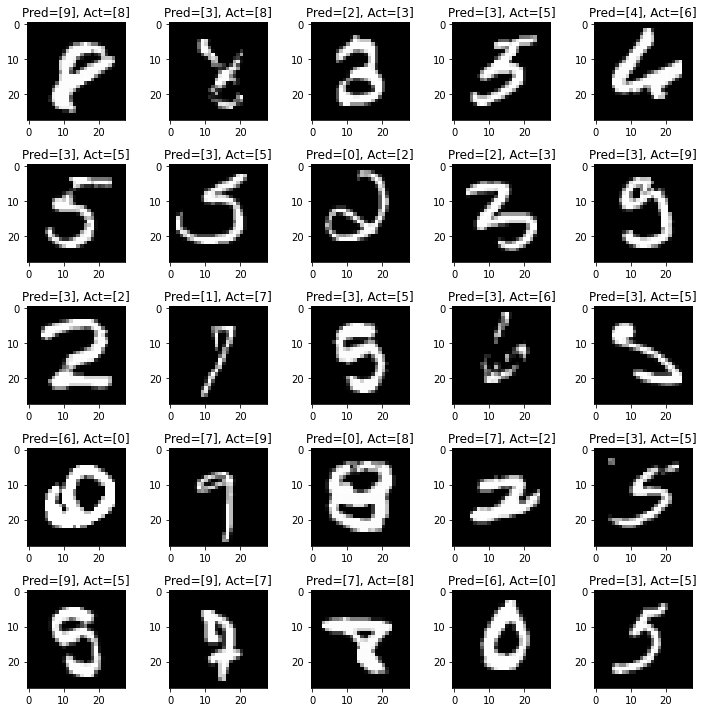

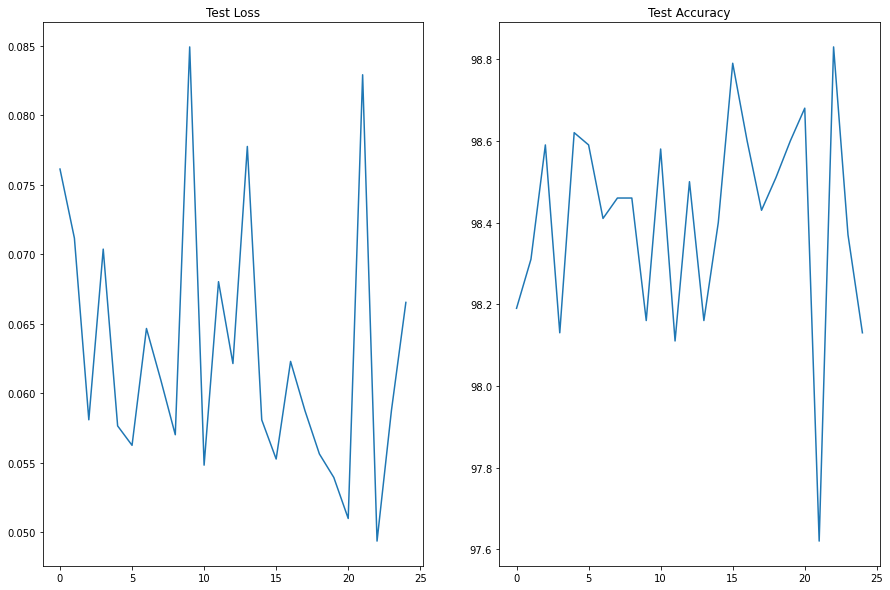

In [14]:
with TrainTestUtils() as utils_obj:
    obj1 = Net()
    device = utils_obj.get_device()
    model =  obj1.to(device)
    l2_regulizer  =  utils_obj.apply_l2_regularizer(model, 0.005)

    utils_obj.display_summary(model, 28)

    utils_obj.train_test_model(model, EPOCHS=EPOCHS, batch_size=BN_BATCHSIZE, optimizer=l2_regulizer)

    bn_misclassifiedL2.extend(utils_obj.misclassifiedImages)
    utils_obj.plot_misclassified(bn_misclassifiedL2)

    bn_test_with_L2_Loss.extend(utils_obj.test_losses)
    bn_test_with_L2_acc.extend(utils_obj.test_acc)

    utils_obj.plot_test_loss_acc(bn_test_with_L2_Loss, bn_test_with_L2_acc)

device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
       BatchNorm2d-7           [-1, 20, 24, 24]              40
         Dropout2d-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 20, 10, 10]           1,800
             ReLU-12           [-1, 20, 10, 10]               0
      BatchNorm2d-13           [-1, 20, 10, 10]              40
        Dropout2d-14           [

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/1875 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Train Set: Train Loss=0.5471304655075073 Batch_id=1874 Accuracy=88.15: 100%|██████████| 1875/1875 [00:27<00:00, 68.89it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  295

Test set: Average loss: 0.0947, Accuracy: 9705/10000 (97.05%)

EPOCH: 2


Train Set: Train Loss=0.5621868371963501 Batch_id=1874 Accuracy=94.85: 100%|██████████| 1875/1875 [00:27<00:00, 69.29it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  177

Test set: Average loss: 0.0559, Accuracy: 9823/10000 (98.23%)

EPOCH: 3


Train Set: Train Loss=0.3173467516899109 Batch_id=1874 Accuracy=95.54: 100%|██████████| 1875/1875 [00:28<00:00, 66.84it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  176

Test set: Average loss: 0.0572, Accuracy: 9824/10000 (98.24%)

EPOCH: 4


Train Set: Train Loss=0.3162779211997986 Batch_id=1874 Accuracy=95.60: 100%|██████████| 1875/1875 [00:26<00:00, 69.82it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  162

Test set: Average loss: 0.0516, Accuracy: 9838/10000 (98.38%)

EPOCH: 5


Train Set: Train Loss=0.39781856536865234 Batch_id=1874 Accuracy=95.89: 100%|██████████| 1875/1875 [00:27<00:00, 69.17it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  173

Test set: Average loss: 0.0553, Accuracy: 9827/10000 (98.27%)

EPOCH: 6


Train Set: Train Loss=0.31525978446006775 Batch_id=1874 Accuracy=95.92: 100%|██████████| 1875/1875 [00:26<00:00, 69.72it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  170

Test set: Average loss: 0.0526, Accuracy: 9830/10000 (98.30%)

EPOCH: 7


Train Set: Train Loss=0.40752482414245605 Batch_id=1874 Accuracy=95.99: 100%|██████████| 1875/1875 [00:27<00:00, 69.13it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  124

Test set: Average loss: 0.0405, Accuracy: 9876/10000 (98.76%)

EPOCH: 8


Train Set: Train Loss=0.3754102289676666 Batch_id=1874 Accuracy=96.03: 100%|██████████| 1875/1875 [00:27<00:00, 68.44it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  155

Test set: Average loss: 0.0502, Accuracy: 9845/10000 (98.45%)

EPOCH: 9


Train Set: Train Loss=0.3775056302547455 Batch_id=1874 Accuracy=96.03: 100%|██████████| 1875/1875 [00:26<00:00, 69.46it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  136

Test set: Average loss: 0.0451, Accuracy: 9864/10000 (98.64%)

EPOCH: 10


Train Set: Train Loss=0.47386106848716736 Batch_id=1874 Accuracy=96.10: 100%|██████████| 1875/1875 [00:27<00:00, 68.97it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  189

Test set: Average loss: 0.0611, Accuracy: 9811/10000 (98.11%)

EPOCH: 11


Train Set: Train Loss=0.28917574882507324 Batch_id=1874 Accuracy=96.03: 100%|██████████| 1875/1875 [00:27<00:00, 68.75it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  132

Test set: Average loss: 0.0407, Accuracy: 9868/10000 (98.68%)

EPOCH: 12


Train Set: Train Loss=0.4594816565513611 Batch_id=1874 Accuracy=96.09: 100%|██████████| 1875/1875 [00:27<00:00, 68.36it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  147

Test set: Average loss: 0.0506, Accuracy: 9853/10000 (98.53%)

EPOCH: 13


Train Set: Train Loss=0.40449967980384827 Batch_id=1874 Accuracy=95.96: 100%|██████████| 1875/1875 [00:27<00:00, 68.62it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  140

Test set: Average loss: 0.0445, Accuracy: 9860/10000 (98.60%)

EPOCH: 14


Train Set: Train Loss=0.49382176995277405 Batch_id=1874 Accuracy=96.14: 100%|██████████| 1875/1875 [00:27<00:00, 68.34it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  158

Test set: Average loss: 0.0497, Accuracy: 9842/10000 (98.42%)

EPOCH: 15


Train Set: Train Loss=0.49175095558166504 Batch_id=1874 Accuracy=96.02: 100%|██████████| 1875/1875 [00:26<00:00, 69.67it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  143

Test set: Average loss: 0.0419, Accuracy: 9857/10000 (98.57%)

EPOCH: 16


Train Set: Train Loss=0.3949180841445923 Batch_id=1874 Accuracy=96.16: 100%|██████████| 1875/1875 [00:27<00:00, 68.66it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  147

Test set: Average loss: 0.0458, Accuracy: 9853/10000 (98.53%)

EPOCH: 17


Train Set: Train Loss=0.30182740092277527 Batch_id=1874 Accuracy=96.19: 100%|██████████| 1875/1875 [00:26<00:00, 69.72it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  153

Test set: Average loss: 0.0481, Accuracy: 9847/10000 (98.47%)

EPOCH: 18


Train Set: Train Loss=0.3404690623283386 Batch_id=1874 Accuracy=96.20: 100%|██████████| 1875/1875 [00:27<00:00, 68.81it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  143

Test set: Average loss: 0.0473, Accuracy: 9857/10000 (98.57%)

EPOCH: 19


Train Set: Train Loss=0.30435052514076233 Batch_id=1874 Accuracy=96.03: 100%|██████████| 1875/1875 [00:27<00:00, 68.54it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  141

Test set: Average loss: 0.0458, Accuracy: 9859/10000 (98.59%)

EPOCH: 20


Train Set: Train Loss=0.4951729476451874 Batch_id=1874 Accuracy=96.19: 100%|██████████| 1875/1875 [00:28<00:00, 66.57it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  127

Test set: Average loss: 0.0420, Accuracy: 9873/10000 (98.73%)

EPOCH: 21


Train Set: Train Loss=0.4441600441932678 Batch_id=1874 Accuracy=96.15: 100%|██████████| 1875/1875 [00:28<00:00, 65.52it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  187

Test set: Average loss: 0.0598, Accuracy: 9813/10000 (98.13%)

EPOCH: 22


Train Set: Train Loss=0.4550371766090393 Batch_id=1874 Accuracy=96.18: 100%|██████████| 1875/1875 [00:28<00:00, 65.05it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  129

Test set: Average loss: 0.0403, Accuracy: 9871/10000 (98.71%)

EPOCH: 23


Train Set: Train Loss=0.2711716294288635 Batch_id=1874 Accuracy=96.31: 100%|██████████| 1875/1875 [00:28<00:00, 65.44it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  148

Test set: Average loss: 0.0506, Accuracy: 9852/10000 (98.52%)

EPOCH: 24


Train Set: Train Loss=0.37337973713874817 Batch_id=1874 Accuracy=96.09: 100%|██████████| 1875/1875 [00:28<00:00, 65.14it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  141

Test set: Average loss: 0.0452, Accuracy: 9859/10000 (98.59%)

EPOCH: 25


Train Set: Train Loss=0.3040885925292969 Batch_id=1874 Accuracy=96.24: 100%|██████████| 1875/1875 [00:28<00:00, 65.20it/s]


Number of miscalssified Images =  172

Test set: Average loss: 0.0550, Accuracy: 9828/10000 (98.28%)



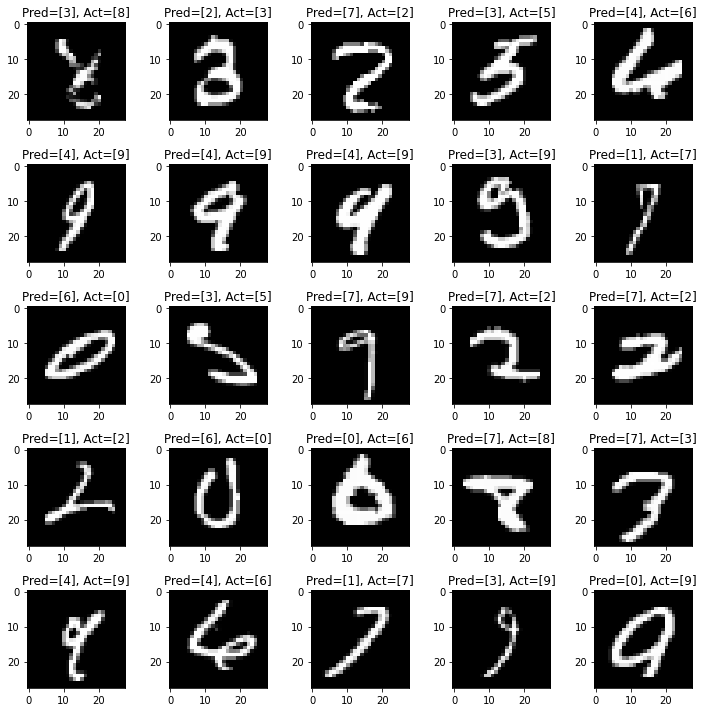

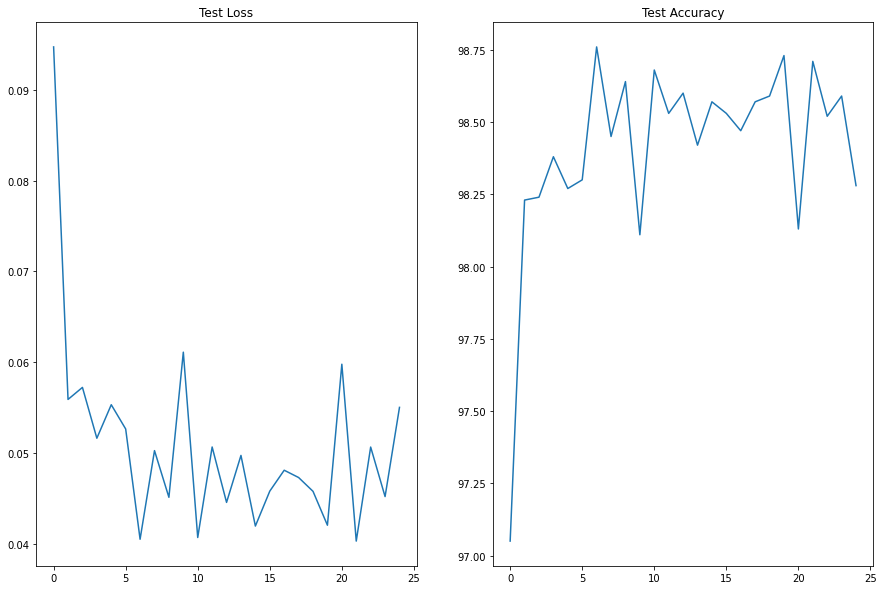

In [15]:
with TrainTestUtils() as utils_obj:
    obj1 = Net()
    device = utils_obj.get_device()
    model =  obj1.to(device)

    utils_obj.display_summary(model, 28)

    utils_obj.train_test_model(model, EPOCHS=EPOCHS, batch_size=BN_BATCHSIZE, l1_factor=0.0005)

    bn_misclassifiedL1.extend(utils_obj.misclassifiedImages)
    utils_obj.plot_misclassified(bn_misclassifiedL1)

    bn_test_with_L1_Loss.extend(utils_obj.test_losses)
    bn_test_with_L1_acc.extend(utils_obj.test_acc)

    utils_obj.plot_test_loss_acc(bn_test_with_L1_Loss, bn_test_with_L1_acc)

device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
       BatchNorm2d-7           [-1, 20, 24, 24]              40
         Dropout2d-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 20, 10, 10]           1,800
             ReLU-12           [-1, 20, 10, 10]               0
      BatchNorm2d-13           [-1, 20, 10, 10]              40
        Dropout2d-14           [

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/1875 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Train Set: Train Loss=0.5190211534500122 Batch_id=1874 Accuracy=87.40: 100%|██████████| 1875/1875 [00:30<00:00, 61.94it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  330

Test set: Average loss: 0.1291, Accuracy: 9670/10000 (96.70%)

EPOCH: 2


Train Set: Train Loss=0.6264603137969971 Batch_id=1874 Accuracy=93.37: 100%|██████████| 1875/1875 [00:29<00:00, 63.13it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  275

Test set: Average loss: 0.1074, Accuracy: 9725/10000 (97.25%)

EPOCH: 3


Train Set: Train Loss=0.3717772960662842 Batch_id=1874 Accuracy=94.00: 100%|██████████| 1875/1875 [00:28<00:00, 65.38it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  271

Test set: Average loss: 0.1057, Accuracy: 9729/10000 (97.29%)

EPOCH: 4


Train Set: Train Loss=0.3066932260990143 Batch_id=1874 Accuracy=94.09: 100%|██████████| 1875/1875 [00:28<00:00, 66.09it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  241

Test set: Average loss: 0.0942, Accuracy: 9759/10000 (97.59%)

EPOCH: 5


Train Set: Train Loss=0.37437936663627625 Batch_id=1874 Accuracy=94.27: 100%|██████████| 1875/1875 [00:29<00:00, 63.77it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  343

Test set: Average loss: 0.1188, Accuracy: 9657/10000 (96.57%)

EPOCH: 6


Train Set: Train Loss=0.30621030926704407 Batch_id=1874 Accuracy=94.46: 100%|██████████| 1875/1875 [00:29<00:00, 64.37it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  170

Test set: Average loss: 0.0714, Accuracy: 9830/10000 (98.30%)

EPOCH: 7


Train Set: Train Loss=0.6398735046386719 Batch_id=1874 Accuracy=94.52: 100%|██████████| 1875/1875 [00:29<00:00, 63.06it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  251

Test set: Average loss: 0.0891, Accuracy: 9749/10000 (97.49%)

EPOCH: 8


Train Set: Train Loss=0.408355712890625 Batch_id=1874 Accuracy=94.50: 100%|██████████| 1875/1875 [00:28<00:00, 64.80it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  210

Test set: Average loss: 0.0791, Accuracy: 9790/10000 (97.90%)

EPOCH: 9


Train Set: Train Loss=0.3724921941757202 Batch_id=1874 Accuracy=94.72: 100%|██████████| 1875/1875 [00:28<00:00, 65.47it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  240

Test set: Average loss: 0.0906, Accuracy: 9760/10000 (97.60%)

EPOCH: 10


Train Set: Train Loss=0.39694803953170776 Batch_id=1874 Accuracy=94.58: 100%|██████████| 1875/1875 [00:27<00:00, 67.25it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  237

Test set: Average loss: 0.0909, Accuracy: 9763/10000 (97.63%)

EPOCH: 11


Train Set: Train Loss=0.35993146896362305 Batch_id=1874 Accuracy=94.59: 100%|██████████| 1875/1875 [00:27<00:00, 67.31it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  293

Test set: Average loss: 0.1119, Accuracy: 9707/10000 (97.07%)

EPOCH: 12


Train Set: Train Loss=0.4359627962112427 Batch_id=1874 Accuracy=94.63: 100%|██████████| 1875/1875 [00:28<00:00, 66.88it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  177

Test set: Average loss: 0.0803, Accuracy: 9823/10000 (98.23%)

EPOCH: 13


Train Set: Train Loss=0.41445302963256836 Batch_id=1874 Accuracy=94.69: 100%|██████████| 1875/1875 [00:28<00:00, 66.90it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  199

Test set: Average loss: 0.0814, Accuracy: 9801/10000 (98.01%)

EPOCH: 14


Train Set: Train Loss=0.6906664371490479 Batch_id=1874 Accuracy=94.65: 100%|██████████| 1875/1875 [00:27<00:00, 67.59it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  271

Test set: Average loss: 0.1012, Accuracy: 9729/10000 (97.29%)

EPOCH: 15


Train Set: Train Loss=0.4374321401119232 Batch_id=1874 Accuracy=94.46: 100%|██████████| 1875/1875 [00:30<00:00, 62.32it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  322

Test set: Average loss: 0.1199, Accuracy: 9678/10000 (96.78%)

EPOCH: 16


Train Set: Train Loss=0.41847842931747437 Batch_id=1874 Accuracy=94.69: 100%|██████████| 1875/1875 [00:32<00:00, 58.12it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  171

Test set: Average loss: 0.0715, Accuracy: 9829/10000 (98.29%)

EPOCH: 17


Train Set: Train Loss=0.3432679772377014 Batch_id=1874 Accuracy=94.50: 100%|██████████| 1875/1875 [00:28<00:00, 66.32it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  240

Test set: Average loss: 0.0957, Accuracy: 9760/10000 (97.60%)

EPOCH: 18


Train Set: Train Loss=0.44496631622314453 Batch_id=1874 Accuracy=94.50: 100%|██████████| 1875/1875 [00:28<00:00, 66.50it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  268

Test set: Average loss: 0.0973, Accuracy: 9732/10000 (97.32%)

EPOCH: 19


Train Set: Train Loss=0.29749101400375366 Batch_id=1874 Accuracy=94.41: 100%|██████████| 1875/1875 [00:28<00:00, 65.34it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  184

Test set: Average loss: 0.0829, Accuracy: 9816/10000 (98.16%)

EPOCH: 20


Train Set: Train Loss=0.428472101688385 Batch_id=1874 Accuracy=94.46: 100%|██████████| 1875/1875 [00:28<00:00, 65.96it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  227

Test set: Average loss: 0.0904, Accuracy: 9773/10000 (97.73%)

EPOCH: 21


Train Set: Train Loss=0.3909441828727722 Batch_id=1874 Accuracy=94.41: 100%|██████████| 1875/1875 [00:28<00:00, 66.40it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  231

Test set: Average loss: 0.0879, Accuracy: 9769/10000 (97.69%)

EPOCH: 22


Train Set: Train Loss=0.4463701844215393 Batch_id=1874 Accuracy=94.41: 100%|██████████| 1875/1875 [00:28<00:00, 65.58it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  444

Test set: Average loss: 0.1530, Accuracy: 9556/10000 (95.56%)

EPOCH: 23


Train Set: Train Loss=0.29980599880218506 Batch_id=1874 Accuracy=94.62: 100%|██████████| 1875/1875 [00:28<00:00, 66.44it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  196

Test set: Average loss: 0.0777, Accuracy: 9804/10000 (98.04%)

EPOCH: 24


Train Set: Train Loss=0.40359771251678467 Batch_id=1874 Accuracy=94.58: 100%|██████████| 1875/1875 [00:28<00:00, 65.60it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  248

Test set: Average loss: 0.0945, Accuracy: 9752/10000 (97.52%)

EPOCH: 25


Train Set: Train Loss=0.32150349020957947 Batch_id=1874 Accuracy=94.46: 100%|██████████| 1875/1875 [00:28<00:00, 65.68it/s]


Number of miscalssified Images =  256

Test set: Average loss: 0.0961, Accuracy: 9744/10000 (97.44%)



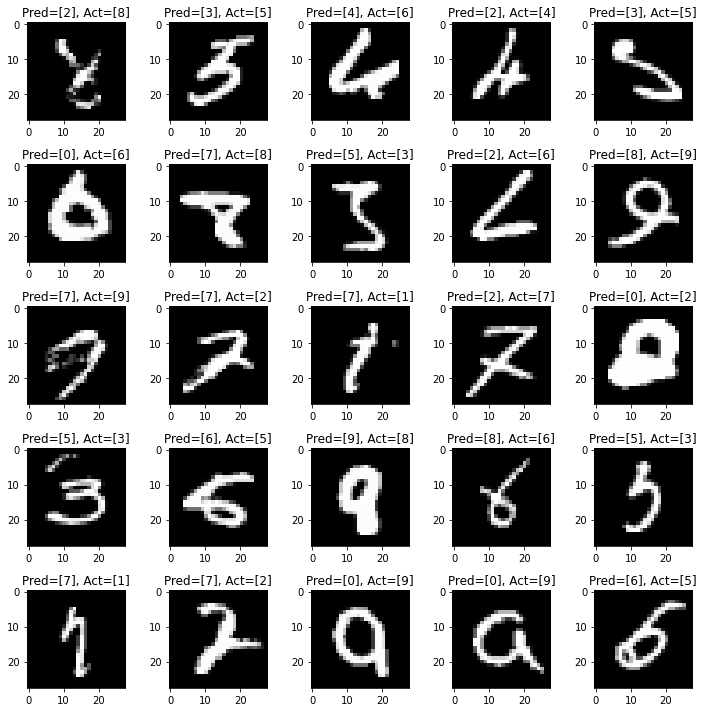

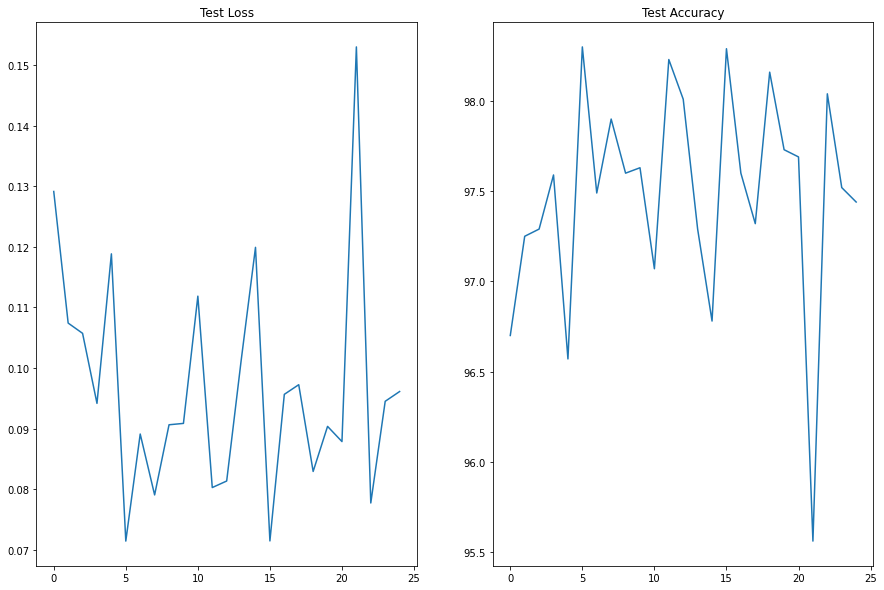

In [16]:
with TrainTestUtils() as utils_obj:
    obj1 = Net()
    device = utils_obj.get_device()
    model =  obj1.to(device)
    l2_regulizer  =  utils_obj.apply_l2_regularizer(model, 0.005)

    utils_obj.display_summary(model, 28)

    utils_obj.train_test_model(model, EPOCHS=EPOCHS, batch_size=BN_BATCHSIZE, l1_factor=0.0005, optimizer=l2_regulizer)

    bn_misclassifiedL1L2.extend(utils_obj.misclassifiedImages)
    utils_obj.plot_misclassified(bn_misclassifiedwithoutL1L2)

    bn_test_with_L1L2_Loss.extend(utils_obj.test_losses)
    bn_test_with_L1L2_acc.extend(utils_obj.test_acc)

    utils_obj.plot_test_loss_acc(bn_test_with_L1L2_Loss, bn_test_with_L1L2_acc)

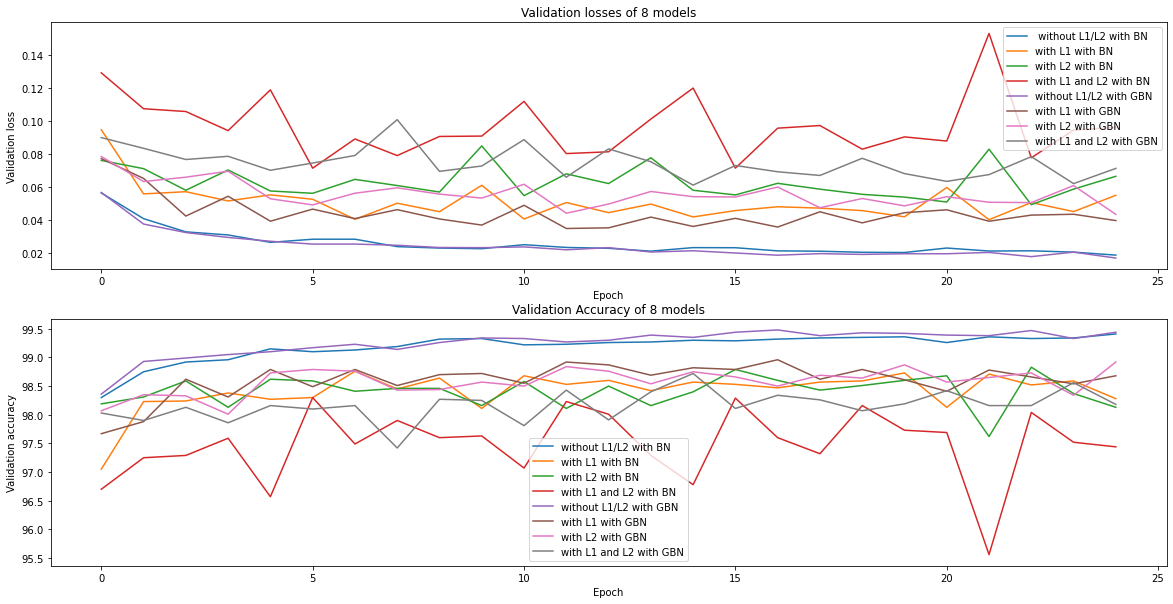

In [17]:

fig, axs = plt.subplots(2,1, figsize=(20,10))
axs[0].plot(bn_test_without_L1L2_Loss, label=' without L1/L2 with BN')
axs[0].plot(bn_test_with_L1_Loss, label='with L1 with BN')
axs[0].plot(bn_test_with_L2_Loss, label='with L2 with BN')
axs[0].plot(bn_test_with_L1L2_Loss, label='with L1 and L2 with BN')

axs[0].plot(gbn_test_without_L1L2_Loss, label='without L1/L2 with GBN')
axs[0].plot(gbn_test_with_L1_Loss, label='with L1 with GBN')
axs[0].plot(gbn_test_with_L2_Loss, label='with L2 with GBN')
axs[0].plot(gbn_test_with_L1L2_Loss, label='with L1 and L2 with GBN')

axs[0].set(title="Validation losses of 8 models", xlabel="Epoch", ylabel="Validation loss")


axs[0].legend(loc='best')

axs[1].plot(bn_test_without_L1L2_acc, label='without L1/L2 with BN')
axs[1].plot(bn_test_with_L1_acc, label='with L1 with BN')
axs[1].plot(bn_test_with_L2_acc, label='with L2 with BN')
axs[1].plot(bn_test_with_L1L2_acc, label='with L1 and L2 with BN')

axs[1].plot(gbn_test_without_L1L2_acc, label='without L1/L2 with GBN')
axs[1].plot(gbn_test_with_L1_acc, label='with L1 with GBN')
axs[1].plot(gbn_test_with_L2_acc, label='with L2 with GBN')
axs[1].plot(gbn_test_with_L1L2_acc, label='with L1 and L2 with GBN')

axs[1].set(title="Validation Accuracy of 8 models", xlabel="Epoch", ylabel="Validation accuracy")
axs[1].legend(loc='best')